In [1]:
# Set up libraries
import numpy as np
import pdb as pdb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import rioxarray as rxr
import pandas as pd
import math
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
# Define global constants
air_index_of_refraction = 1.0003
c = 2.99792458e8   
number_of_waveform_files = 100000

# Set the WGS84 ellipsoid to NAD83 Geoid height offset for LVIS and GEDI
ellipsoid_to_geoid_offset = 29.2548 # Harvard Forest, MA


In [3]:
# Define AOP pulsewaves directory, file, and constants

aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'
# waveform_file = aop_data_dir + 'NEON_D01_HARV_DP1_L008-1_2019081112.plz'

lidar_sensor_name = 'AOP'
lidar_instrument_name_2019 = 'Gemini'
lidar_instrument_name_2022 = 'LMS-Q780'
lidar_instrument_name_2024 = 'Galaxy2024'

# Define the waveform signal detection level - set by Dr. Keith Krause
detection_threshold_2019 = 32.0
detection_threshold_2022 = 8.0
detection_threshold_2024 = 32.0 * 5.0

# Set lidar instrument name and detection threshold based on current year of pulsewaves data
lidar_instrument_name = lidar_instrument_name_2019
detection_threshold = detection_threshold_2019


In [4]:
def waveform_peak_detection(waveform, waveform_intensity_threshold):
    """
    A simple function to detect peaks in the waveform
    Written by Dr. Keith Krause
    """
    # Define x grid
    x_grid = np.arange(0.0,len(waveform),1.0)

    # Calculate 1st and 2nd derivatives
    deriv_1st = np.gradient(waveform,axis=0,edge_order=1)
    deriv_2nd = np.gradient(deriv_1st,axis=0,edge_order=1)

    #Find locations where 1st derivative crosses 0: (deriv_1st[i] * deriv_1st[i-1] = negative value)
    mult_shift_deriv_1st = deriv_1st * np.roll(deriv_1st,1)
    zero_slope_aoi = np.argwhere(mult_shift_deriv_1st <= 0.0)
    zero_slope_aoi = zero_slope_aoi[:,0]
    zero_slope_count = len(zero_slope_aoi)
    if zero_slope_count > 0:
        zero_slope_aoi = np.reshape(zero_slope_aoi,len(zero_slope_aoi))

    if zero_slope_count == 0:
        return_location_count = 0
        return_peak_location_list = -9999
        return_location_list_x = -9999
        return_intensity_list = -9999    
    else:
        if zero_slope_count == 1:    
            if zero_slope_aoi == 0:
                return_location_count = 0
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            else:
                if deriv_2nd[zero_slope_aoi] < 0.0:
                    return_location_count = 1
                    return_peak_location_list = zero_slope_aoi
                    return_location_list_x = x_grid[zero_slope_aoi]
                    return_intensity_list = waveform[zero_slope_aoi]               
                else:
                    return_location_count = 0
                    return_peak_location_list = -9999
                    return_location_list_x = -9999
                    return_intensity_list = -9999    
        else:
            # Remove bin 0 if included in list
            if zero_slope_aoi[0] == 0:
                zero_slope_aoi = zero_slope_aoi[1:zero_slope_count]
                zero_slope_count = zero_slope_count - 1     

            # Remove sequential bins if included in list and keep first                
            zero_slope_aoi_diff = zero_slope_aoi - np.roll(zero_slope_aoi,1)
            good_zero_slope_aoi = np.argwhere(zero_slope_aoi_diff != 1)
            good_zero_slope_aoi = np.reshape(good_zero_slope_aoi,len(good_zero_slope_aoi))
            zero_slope_aoi = zero_slope_aoi[good_zero_slope_aoi]
            zero_slope_count = len(good_zero_slope_aoi)
            zero_slope_aoi_diff = 0
            good_zero_slope_aoi = 0    
               
            # Return peaks will have a negative 2nd derivative
            peak_locations_aoi = np.argwhere(deriv_2nd[zero_slope_aoi] < 0.0)
            return_location_count = len(peak_locations_aoi)
            if return_location_count > 0:
                peak_locations_aoi = peak_locations_aoi[:,0]
                peak_locations_aoi = np.reshape(peak_locations_aoi,len(peak_locations_aoi))
                return_peak_location_list = zero_slope_aoi[peak_locations_aoi]
                return_location_list_x = x_grid[zero_slope_aoi[peak_locations_aoi]]
                return_intensity_list = waveform[return_peak_location_list]
            else:
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            peak_locations_aoi = 0

    if return_location_count > 0:
        return_peak_location_list = np.reshape(return_peak_location_list,return_location_count)
        return_location_list_x = np.reshape(return_location_list_x,return_location_count)
        return_intensity_list = np.reshape(return_intensity_list,return_location_count)
                     
    # Remove peaks with peak location at first 2 bins
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_peak_location_list > 1)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0                    

    # Check intensity values for valid peaks
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_intensity_list >= waveform_intensity_threshold)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0    
    
    x_grid = 0
    deriv_1st = 0
    deriv_2nd = 0
    mult_shift_deriv_1st = 0
    zero_slope_aoi = 0
    waveform = 0
    return return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list

In [5]:
def read_NEONAOP_pulsewaves_pulse_information_header_only(pls_file, lidar_instrument_name):
    """
    Only reads PulseWaves (PLS) file metadata and pulse information with no geolocation information, returning
    instrument name, number of pulses, anchor positions, wave offsets, etc.
    Written by Dr. Keith Krause with modifications by Felix Yu
    """

    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)

    # Read PulseWaves Header
    file_signature = np.fromfile(readbin_pls_file,np.int8,16)
    global_parameters = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    file_source_id = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    project_id_guid_data1 = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    project_id_guid_data2 = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1))
    project_id_guid_data3 = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1))
    project_id_guid_data4 = np.fromfile(readbin_pls_file,np.uint8,8)
    system_identifier = np.fromfile(readbin_pls_file,np.int8,64)    
    generating_software = np.fromfile(readbin_pls_file,np.int8,64)
    file_creation_day_of_year = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1))
    file_creation_year = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1))
    version_major = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1))
    version_minor = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1))
    header_size = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1))
    offset_to_pulse_data = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    number_of_pulses = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    pulse_format = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    pulse_attributes = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    pulse_size = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    pulse_compression = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    reserved = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    number_of_variable_length_records = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
    number_of_appended_variable_length_records = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))
    T_scale_factor = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    T_offset = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    min_T = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    max_T = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    x_scale_factor = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    y_scale_factor = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    z_scale_factor = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    x_offset = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    y_offset = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    z_offset = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    min_x = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    max_x = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    min_y = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    max_y = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    min_z = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))
    max_z = np.ndarray.item(np.fromfile(readbin_pls_file,np.double,1))

    # Read variable length records
    vlr_user_id = []
    vlr_record_id = []
    vlr_reserved = []
    vlr_record_length_after_header = []
    vlr_description = []
    vlr_data = []
    pulse_descriptor_size = [] 
    pulse_descriptor_reserved = [] 
    pulse_descriptor_optical_center_to_anchor_point = []
    pulse_descriptor_number_of_extra_wave_bytes = []
    pulse_descriptor_number_of_samplings = [] 
    pulse_descriptor_sample_units = [] 
    pulse_descriptor_compression = [] 
    pulse_descriptor_scanner_index = [] 
    pulse_descriptor_description = []
    sampling_record_size = []
    sampling_record_reserved = []
    sampling_record_type = []
    sampling_record_channel = []
    sampling_record_unused = []
    sampling_record_bits_for_duration_from_anchor = []
    sampling_record_scale_for_duration_from_anchor = []
    sampling_record_offset_for_duration_from_anchor = []
    sampling_record_bits_for_number_of_segments = []
    sampling_record_bits_for_number_of_samples = []
    sampling_record_number_of_segments = []
    sampling_record_number_of_samples = []
    sampling_record_bits_per_sample = []
    sampling_record_lookup_table_index = []
    sampling_record_sample_units = []
    sampling_record_compression = []
    sampling_record_description = []
    num_pulse_descriptor_records = 0
    sampling_record_pulse_descriptor_index_lookup = []

    for i in range(0,int(number_of_variable_length_records)):
        vlr_user_id.append(np.fromfile(readbin_pls_file,np.int8,16))
        vlr_record_id.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
        vlr_reserved.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
        vlr_record_length_after_header.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1)))
        vlr_description.append(np.fromfile(readbin_pls_file,np.int8,64))
        if(vlr_record_id[i] >= 100001 and vlr_record_id[i] < 100255):
            scanner_size = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
            scanner_reserved = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
            scanner_instrument = np.fromfile(readbin_pls_file,np.int8,64)
            scanner_serial = np.fromfile(readbin_pls_file,np.int8,64)
            scanner_wave_length = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_outgoing_pulse_width = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_scan_pattern = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
            scanner_number_of_mirror_facets = np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1))
            scanner_scan_frequency = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_scan_angle_min = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_scan_angle_max = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_pulse_frequency = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_beam_diameter_at_exit_apertrue = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_beam_divergence = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_minimal_range = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_maximal_range = np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1))
            scanner_description = np.fromfile(readbin_pls_file,np.int8,64)
            continue     
        if (vlr_record_id[i] >= 20001 and vlr_record_id[i] < 200255):
            pulse_descriptor_index = vlr_record_id[i] - 200000
            pulse_descriptor_size.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
            pulse_descriptor_reserved.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
            pulse_descriptor_optical_center_to_anchor_point.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1)))
            pulse_descriptor_number_of_extra_wave_bytes.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1)))
            pulse_descriptor_number_of_samplings.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1)))
            pulse_descriptor_sample_units.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1)))
            pulse_descriptor_compression.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
            pulse_descriptor_scanner_index.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
            pulse_descriptor_description1 = np.fromfile(readbin_pls_file,np.int8,64)
            pulse_descriptor_description.append(pulse_descriptor_description1)
            num_pulse_descriptor_records = num_pulse_descriptor_records + 1
            for j in range(0,int(pulse_descriptor_number_of_samplings[-1])):
                sampling_record_pulse_descriptor_index_lookup.append(pulse_descriptor_index)
                sampling_record_size.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
                sampling_record_reserved.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
                sampling_record_type.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_channel.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_unused.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_bits_for_duration_from_anchor.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_scale_for_duration_from_anchor.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1)))
                sampling_record_offset_for_duration_from_anchor.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1)))
                sampling_record_bits_for_number_of_segments.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_bits_for_number_of_samples.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint8,1)))
                sampling_record_number_of_segments.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1)))
                sampling_record_number_of_samples.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
                sampling_record_bits_per_sample.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1)))
                sampling_record_lookup_table_index.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint16,1)))
                sampling_record_sample_units.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.float32,1)))
                sampling_record_compression.append(np.ndarray.item(np.fromfile(readbin_pls_file,np.uint32,1)))
                sampling_record_description1 = np.fromfile(readbin_pls_file,np.int8,64)
                sampling_record_description.append(sampling_record_description1)
            continue
        vlr_data.append(np.fromfile(readbin_pls_file,np.uint8,int(vlr_record_length_after_header[i])))
        
    # Reshape pulse descriptor and sampling record arrays
    # pulse_descriptor_description and sampling_record_description not included
    pulse_descriptor_size_array = np.reshape(pulse_descriptor_size,len(pulse_descriptor_size))
    pulse_descriptor_reserved_array = np.reshape(pulse_descriptor_reserved,len(pulse_descriptor_reserved))
    pulse_descriptor_optical_center_to_anchor_point_array = np.reshape(pulse_descriptor_optical_center_to_anchor_point,len(pulse_descriptor_optical_center_to_anchor_point))
    pulse_descriptor_number_of_extra_wave_bytes_array = np.reshape(pulse_descriptor_number_of_extra_wave_bytes,len(pulse_descriptor_number_of_extra_wave_bytes))
    pulse_descriptor_number_of_samplings_array = np.reshape(pulse_descriptor_number_of_samplings,len(pulse_descriptor_number_of_samplings))
    pulse_descriptor_sample_units_array = np.reshape(pulse_descriptor_sample_units,len(pulse_descriptor_sample_units))
    pulse_descriptor_compression_array = np.reshape(pulse_descriptor_compression,len(pulse_descriptor_compression))
    pulse_descriptor_scanner_index_array = np.reshape(pulse_descriptor_scanner_index,len(pulse_descriptor_scanner_index))
    sampling_record_pulse_descriptor_index_lookup_array = np.reshape(sampling_record_pulse_descriptor_index_lookup,len(sampling_record_pulse_descriptor_index_lookup))                               
    sampling_record_size_array = np.reshape(sampling_record_size,len(sampling_record_size))                                                                
    sampling_record_reserved_array = np.reshape(sampling_record_reserved,len(sampling_record_reserved))                                                                 
    sampling_record_type_array = np.reshape(sampling_record_type,len(sampling_record_type))                                                                 
    sampling_record_channel_array = np.reshape(sampling_record_channel,len(sampling_record_channel))                                                                 
    sampling_record_unused_array = np.reshape(sampling_record_unused,len(sampling_record_unused))                                                                 
    sampling_record_bits_for_duration_from_anchor_array = np.reshape(sampling_record_bits_for_duration_from_anchor,len(sampling_record_bits_for_duration_from_anchor))                                                               
    sampling_record_scale_for_duration_from_anchor_array = np.reshape(sampling_record_scale_for_duration_from_anchor,len(sampling_record_scale_for_duration_from_anchor))
    sampling_record_offset_for_duration_from_anchor_array = np.reshape(sampling_record_offset_for_duration_from_anchor,len(sampling_record_offset_for_duration_from_anchor))
    sampling_record_bits_for_number_of_segments_array = np.reshape(sampling_record_bits_for_number_of_segments,len(sampling_record_bits_for_number_of_segments))
    sampling_record_bits_for_number_of_samples_array = np.reshape(sampling_record_bits_for_number_of_samples,len(sampling_record_bits_for_number_of_samples))
    sampling_record_number_of_segments_array = np.reshape(sampling_record_number_of_segments,len(sampling_record_number_of_segments))
    sampling_record_number_of_samples_array = np.reshape(sampling_record_number_of_samples,len(sampling_record_number_of_samples))
    sampling_record_bits_per_sample_array = np.reshape(sampling_record_bits_per_sample,len(sampling_record_bits_per_sample))
    sampling_record_lookup_table_index_array = np.reshape(sampling_record_lookup_table_index,len(sampling_record_lookup_table_index))
    sampling_record_sample_units_array = np.reshape(sampling_record_sample_units,len(sampling_record_sample_units))
    sampling_record_compression_array = np.reshape(sampling_record_compression,len(sampling_record_compression))    
    
    instrument_name = str(scanner_instrument,'UTF-8')
    
    if (instrument_name[0:6] == 'Galaxy'):
        instrument_name = instrument_name[0:6]
    if (instrument_name[0:11] == 'ALTM GEMINI'):
        instrument_name = 'Gemini'
    if (instrument_name[5:9] == 'Q780'):
        instrument_name = 'LMS-Q780'
    if (instrument_name[0:4] == 'Auto'):
        instrument_name = lidar_instrument_name #'Galaxy' #'LMS-Q780'
    
    #if Optech T_offset = 0
    if ((instrument_name == 'Gemini') | (instrument_name == 'Galaxy')):
        T_offset = 0.0

    # Loop through PLS file and get info for all pulses
    gps_timestamp_T_array = np.zeros(number_of_pulses)
    offset_to_waves_array = np.zeros(number_of_pulses)
    anchor_X_array = np.zeros(number_of_pulses)
    anchor_Y_array = np.zeros(number_of_pulses)  
    anchor_Z_array = np.zeros(number_of_pulses)
    target_X_array = np.zeros(number_of_pulses)    
    target_Y_array = np.zeros(number_of_pulses)
    target_Z_array = np.zeros(number_of_pulses)
    first_returning_sample_array = np.zeros(number_of_pulses)
    last_returning_sample_array = np.zeros(number_of_pulses)
    pulse_data_array = np.zeros((np.longlong(number_of_pulses),2))
    intensity_array = np.zeros(number_of_pulses)
    classification_array = np.zeros(number_of_pulses)
    gps_timestamp_array = np.zeros(number_of_pulses)
    xyz_anchor_array = np.zeros((np.longlong(number_of_pulses),3))
    xyz_target_array = np.zeros((np.longlong(number_of_pulses),3))   
    pulse_descriptor_index_array = np.zeros(number_of_pulses)
    dxdydz_array = np.zeros((np.longlong(number_of_pulses),3))   
    xyz_first_array = np.zeros((np.longlong(number_of_pulses),3))   
    xyz_last_array = np.zeros((np.longlong(number_of_pulses),3))   
    
    readbin_pls_file.close()

    # Return instrument_name number of pulses and geolocation for anchor position, first and last waveform bins, and ray vector dxdydz, plus pulsewaves data
    return instrument_name, number_of_pulses, xyz_anchor_array, dxdydz_array, xyz_first_array, xyz_last_array, offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array 


In [6]:
'''Read waveform information for AOP into global variables necessary for future analysis
   Only process a portion of the pulsewaves file: use for quick processing
'''

start = time.time()
waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'

instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information_header_only(pls_file, lidar_instrument_name) 

if (instrument_name == 'Gemini'):
    beam_footprint = 1.13137 # 0.8 1/e
elif (instrument_name == 'Galaxy'):
    beam_footprint = 0.533553 # 0.25 1/e
elif (instrument_name == 'LMS-Q780'):
    beam_footprint = 0.25 # 0.25 1/e^2
else:
    beam_footprint = 0.5
    print("Instrument name not detected")

end = time.time()
print(f"Instrument Name: {instrument_name}")
print(f"Beam Footprint: {beam_footprint}")
print(f"Number of Pulses: {number_of_pulses}")
print(f"Pulse Size: {pulse_size}")


Instrument Name: Gemini
Beam Footprint: 1.13137
Number of Pulses: 28036820
Pulse Size: 48


In [7]:
def read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,instrument_name,lidar_instrument_name,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array):    
    """
    Reads a single waveform (.wvs) file using metadata from Pulse (.pls) file, returning
    intensity, easting, northing, elevation, offset, and if waveform contains multiple segements
    Written by Dr. Keith Krause with modifications by Felix Yu
    """

    readbin_pls_file.seek(0,0)
    readbin_wvs_file.seek(0,0)

    # Read pulse record
    pls_file_offset = np.int64(offset_to_pulse_data) + np.int64(iPulse) * np.int64(pulse_size)
    readbin_pls_file.seek(pls_file_offset,0)
    gps_timestamp_T = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    offset_to_waves = np.ndarray.item(np.fromfile(readbin_pls_file,np.int64,1))
    anchor_X = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))
    anchor_Y = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))    
    anchor_Z = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))
    target_X = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))    
    target_Y = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))   
    target_Z = np.ndarray.item(np.fromfile(readbin_pls_file,np.int32,1))   
    first_returning_sample = np.ndarray.item(np.fromfile(readbin_pls_file,np.int16,1))  
    last_returning_sample = np.ndarray.item(np.fromfile(readbin_pls_file,np.int16,1))  
    pulse_data = np.fromfile(readbin_pls_file,np.int8,2)  
    intensity = np.ndarray.item(np.fromfile(readbin_pls_file,np.int8,1))
    classification = np.ndarray.item(np.fromfile(readbin_pls_file,np.int8,1))
    gps_timestamp = np.double(gps_timestamp_T) * T_scale_factor + T_offset
    x_anchor = np.double(anchor_X) * x_scale_factor + x_offset
    y_anchor = np.double(anchor_Y) * y_scale_factor + y_offset
    z_anchor = np.double(anchor_Z) * z_scale_factor + z_offset
    x_target = np.double(target_X) * x_scale_factor + x_offset    
    y_target = np.double(target_Y) * y_scale_factor + y_offset        
    z_target = np.double(target_Z) * z_scale_factor + z_offset        
    pulse_descriptor_index = pulse_data[0]
    dx = (x_target - x_anchor) / 1000.0
    dy = (y_target - y_anchor) / 1000.0
    dz = (z_target - z_anchor) / 1000.0
    x_first = x_anchor + np.double(first_returning_sample) * dx
    y_first = y_anchor + np.double(first_returning_sample) * dy
    z_first = z_anchor + np.double(first_returning_sample) * dz
    x_last = x_anchor + np.double(last_returning_sample) * dx
    y_last = y_anchor + np.double(last_returning_sample) * dy
    z_last = z_anchor + np.double(last_returning_sample) * dz      
    
    # Read waveforms
    pulse_descriptor_aoi = np.argwhere(sampling_record_pulse_descriptor_index_lookup_array == pulse_descriptor_index)
    pulse_descriptor_aoi = np.reshape(pulse_descriptor_aoi,len(pulse_descriptor_aoi))

    optical_center_to_anchor_point = pulse_descriptor_optical_center_to_anchor_point_array[pulse_descriptor_index-1]
    number_of_extra_wave_bytes = pulse_descriptor_number_of_extra_wave_bytes_array[pulse_descriptor_index-1]
    number_of_samplings = pulse_descriptor_number_of_samplings_array[pulse_descriptor_index-1]

    bits_for_duration_from_anchor_array = sampling_record_bits_for_duration_from_anchor_array[pulse_descriptor_aoi]
    scale_for_duration_from_anchor_array = sampling_record_scale_for_duration_from_anchor_array[pulse_descriptor_aoi]
    offset_for_duration_from_anchor_array = sampling_record_offset_for_duration_from_anchor_array[pulse_descriptor_aoi]
    bits_for_number_of_segments_array = sampling_record_bits_for_number_of_segments_array[pulse_descriptor_aoi]
    bits_for_number_of_samples_array = sampling_record_bits_for_number_of_samples_array[pulse_descriptor_aoi]
    number_of_segments_array = sampling_record_number_of_segments_array[pulse_descriptor_aoi]
    number_of_samples_array = sampling_record_number_of_samples_array[pulse_descriptor_aoi]
    bits_per_sample_array = sampling_record_bits_per_sample_array[pulse_descriptor_aoi]    

    wvs_file_offset = offset_to_waves
    readbin_wvs_file.seek(wvs_file_offset,0)

    if(number_of_extra_wave_bytes > 0):
        extra_wave_bytes = np.fromfile(readbin_wvs_file,np.int8,number_of_extra_wave_bytes)
        
    for iSampling in range(number_of_samplings):
        
        if bits_for_number_of_segments_array[iSampling] != 0:
            number_of_segments_number_of_bits = bits_for_number_of_segments_array[iSampling]
            
            if number_of_segments_number_of_bits == 8:
                number_of_segments = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint8,1))
            elif number_of_segments_number_of_bits == 16:
                number_of_segments = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint16,1))            
            elif number_of_segments_number_of_bits == 32:
                number_of_segments = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint32,1))
        else:
            number_of_segments = number_of_segments_array[iSampling]    

        number_of_segments = np.int16(number_of_segments)
        
        waveform_segments_array = np.zeros((500,number_of_segments))
        number_of_samples_array = np.zeros(number_of_segments)
        scaled_duration_from_anchor_for_segment_array = np.zeros(number_of_segments)                    

        for iSegment in range(number_of_segments):
            duration_from_anchor_number_of_bits = bits_for_duration_from_anchor_array[iSampling]
            
            if duration_from_anchor_number_of_bits == 8:
                duration_from_anchor = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint8,1))
            elif duration_from_anchor_number_of_bits == 16:
                duration_from_anchor = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint16,1))            
            elif duration_from_anchor_number_of_bits == 32:
                duration_from_anchor = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint32,1))
                
            if bits_for_number_of_samples_array[iSampling] != 0:
                number_of_samples_number_of_bits = bits_for_number_of_samples_array[iSampling]    
                if number_of_samples_number_of_bits == 8:
                    number_of_samples = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint8,1))
                elif number_of_samples_number_of_bits == 16:
                    number_of_samples = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint16,1))            
                elif number_of_samples_number_of_bits == 32:
                    number_of_samples = np.ndarray.item(np.fromfile(readbin_wvs_file,np.uint32,1))
            else:
                number_of_samples = number_of_samples_array[iSampling] 
                
            if number_of_samples > 0:   
                bits_per_sample_number_of_bits = bits_per_sample_array[iSampling]
                    
            if bits_per_sample_number_of_bits == 8:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint8,number_of_samples)
            elif bits_per_sample_number_of_bits == 16:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint16,number_of_samples)            
            elif bits_per_sample_number_of_bits == 32:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint32,number_of_samples)
            
            scaled_duration_from_anchor_for_segment = np.double(duration_from_anchor) * scale_for_duration_from_anchor_array[iSampling] + offset_for_duration_from_anchor_array[iSampling]
            
            waveform_segments_array[0:number_of_samples,iSegment] = waveform_segment
            number_of_samples_array[iSegment] = number_of_samples
            scaled_duration_from_anchor_for_segment_array[iSegment] = scaled_duration_from_anchor_for_segment
                                                                
            waveform_segment = 0
                
        number_of_samples_array = np.int16(number_of_samples_array)

        if iSampling == 0:
            neon_waveform_outgoing_pulse = waveform_segments_array[0:number_of_samples_array[0]]
        else:
            scaled_duration_from_anchor_for_segment0 = scaled_duration_from_anchor_for_segment_array[0]
            if ((instrument_name == 'Gemini') | (instrument_name == 'Galaxy')):
                good_segments_aoi = np.argwhere(scaled_duration_from_anchor_for_segment_array > 0)
            else:
                good_segments_aoi = np.argwhere(scaled_duration_from_anchor_for_segment_array > -1)
            good_segments_aoi = np.reshape(good_segments_aoi,len(good_segments_aoi))
            number_of_good_segments = len(good_segments_aoi)
 
            if number_of_good_segments > 1:
                # Combine multiple segments
                neon_waveform_return_pulse = np.zeros(np.int16(scaled_duration_from_anchor_for_segment_array[np.max(good_segments_aoi)] - scaled_duration_from_anchor_for_segment_array[0] + number_of_samples_array[np.max(good_segments_aoi)]))
                for iSegment in range(number_of_good_segments):
                    array_start_pos = np.int16(scaled_duration_from_anchor_for_segment_array[good_segments_aoi[iSegment]] - scaled_duration_from_anchor_for_segment_array[0])
                    neon_waveform_return_pulse[array_start_pos:array_start_pos+number_of_samples_array[good_segments_aoi[iSegment]]] = waveform_segments_array[0:number_of_samples_array[good_segments_aoi[iSegment]],good_segments_aoi[iSegment]]                                                     
            else:
                neon_waveform_return_pulse = waveform_segments_array[0:number_of_samples_array[0]-1,0]
            if iSampling == 1:
                neon_waveform_return_pulse1 = neon_waveform_return_pulse
                neon_waveform_return_pulse2 = 0
            else:
                neon_waveform_return_pulse2 = neon_waveform_return_pulse
                
        waveform_segments_array = 0
        number_of_samples_array = 0
        scaled_duration_from_anchor_for_segment_array = 0    

    neon_waveform_return_pulse = neon_waveform_return_pulse1
        
    # Determine peak location of the outgoing pulse
    outgoing_peak_pos = np.argwhere(neon_waveform_outgoing_pulse == np.max(neon_waveform_outgoing_pulse))
    if len(outgoing_peak_pos) == 1:
        neon_waveform_outgoing_pulse_peak_location = outgoing_peak_pos[0,0]  
    else:
        neon_waveform_outgoing_pulse_peak_location = np.mean(outgoing_peak_pos[:,0])

    # Adjust the duration from anchor from bin0 to the peak location of the outgoing pulse
    if ((instrument_name == 'Gemini') | (instrument_name == 'Galaxy')):
        if lidar_instrument_name == 'Galaxy2024':
            scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 - 0.8*neon_waveform_outgoing_pulse_peak_location
        else:
            scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 - neon_waveform_outgoing_pulse_peak_location
    else:
        scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 #- neon_waveform_outgoing_pulse_peak_location
        
    # Fill in multiple segment gaps with the minimum valid return waveform value, then subtract the min
    return_good_aoi = np.argwhere(neon_waveform_return_pulse > 0)
    return_good_aoi = np.reshape(return_good_aoi,len(return_good_aoi))       
    return_bad_aoi = np.argwhere(neon_waveform_return_pulse == 0)
    return_bad_aoi = np.reshape(return_bad_aoi,len(return_bad_aoi))                          
    if len(return_bad_aoi) > 0:
        neon_waveform_return_pulse[return_bad_aoi] = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_offset = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_return_pulse = neon_waveform_return_pulse - neon_waveform_offset

    # Calculate absolute x,y,z axes for pulse
    if lidar_instrument_name == 'Galaxy2024':
        neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse))*0.8 + scaled_duration_from_anchor_for_segment0_adj) * dx + x_anchor
        neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse))*0.8 + scaled_duration_from_anchor_for_segment0_adj) * dy + y_anchor
        neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse))*0.8 + scaled_duration_from_anchor_for_segment0_adj) * dz + z_anchor
    else:
        # For gemini sensor: don't use adjusted segment, base it on last z-return instead of last peak return
        neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dx + x_anchor
        neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dy + y_anchor
        neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0) * dz + z_anchor

    # Return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis
    return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis, neon_waveform_offset
    
    

In [9]:
def print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, return_peak_locations):
    ground_return_index = np.argmin(waveform_z_axis)
    max_return_index = np.argmax(waveform_z_axis)
    
    ground_easting_coord = waveform_x_axis[ground_return_index]
    ground_northing_coord = waveform_y_axis[ground_return_index]
    max_easting_coord = waveform_x_axis[max_return_index]
    max_northing_coord = waveform_y_axis[max_return_index]
    peak_easting_coord = waveform_x_axis[return_peak_locations]
    peak_northing_coord = waveform_y_axis[return_peak_locations]

    min_easting_coord = min(waveform_x_axis)
    max_easting_coord = max(waveform_x_axis)
    min_northing_coord = min(waveform_y_axis)
    max_northing_coord = max(waveform_y_axis)
    
    print(f"Ground return Easting {ground_easting_coord}, Northing: {ground_northing_coord}")
    print(f"Max height return Easting {max_easting_coord}, Northing: {max_northing_coord}")
    print(f"Peak location easting: {peak_easting_coord}, northing: {peak_northing_coord}")
    print(f"Min easting value: {min_easting_coord}, Max easting value: {max_easting_coord}")
    print(f"Min northing value: {min_northing_coord}, Max northing value: {max_northing_coord}")
    return

Ground return Easting 726502.3838599994, Northing: 4699045.362800004
Max height return Easting 726502.3838599994, Northing: 4699045.378000003
Peak location easting: [], northing: []
Min easting value: 726502.2405999994, Max easting value: 726502.3838599994
Min northing value: 4699045.362800004, Max northing value: 4699045.378000003


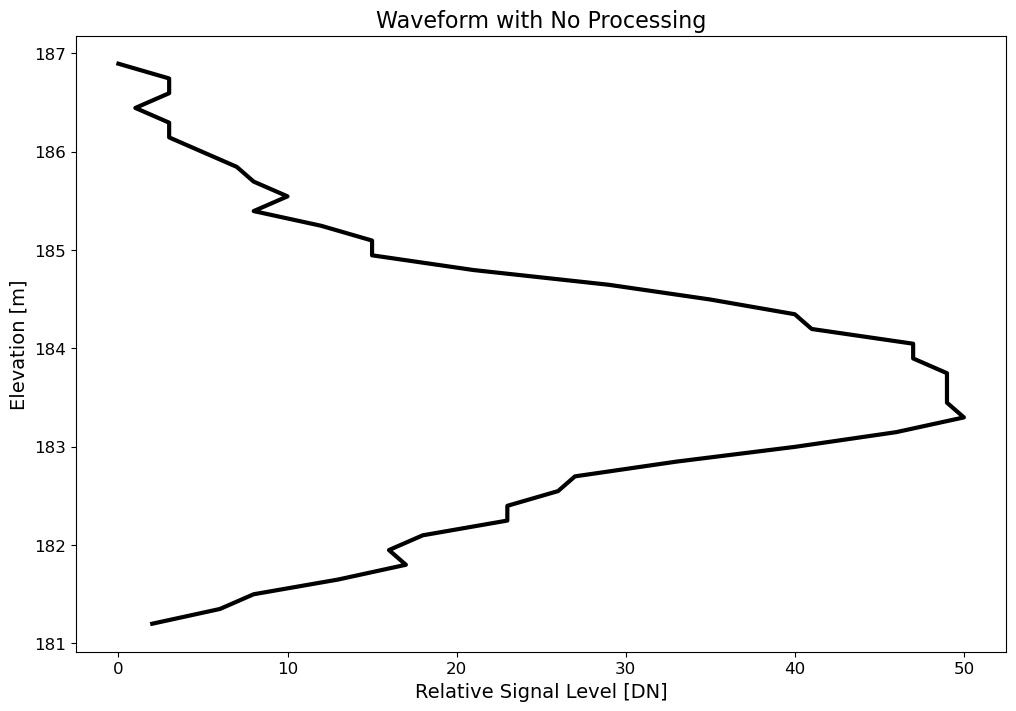

In [10]:
'''Test waveform processing by graphing a raw waveform'''
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

# Index of pulsewaves array to read
iPulse = 3595429
    
# Read waveform
waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,instrument_name,lidar_instrument_name,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
waveform_intensity_threshold = 10.0

# Peak location indices
return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)
print_waveform_location_information(waveform_x_axis, waveform_y_axis, waveform_z_axis, [])

ax1.tick_params(axis='both',which='major',labelsize=12)
ax1.set_title('Waveform with No Processing', size = 16)
ax1.set_xlabel('Relative Signal Level [DN]', size = 14)
ax1.set_ylabel('Elevation [m]', size = 14)
ax1.plot(waveform,waveform_z_axis,color='black',linewidth=3,zorder=1)

readbin_pls_file.close()
readbin_wvs_file.close()

In [11]:
def normalize_cumulative_return_energy(waveform_intensity_x, waveform_elevation_y, plot):
    '''Normalize cumulative return energy from waveform intensity values, with x being normalized intensity and y being elevation in meters.
       Returns a 2D stacked array with format [intensity1, elevation1, intensity2, elevation2, ...]'''

    # Create normalized cumulative signal energy from waveform intensity values
    cumulative_energy_RH_boundaries = [0.25, 0.5, 0.75, 1.0]
    
    # Turn elevation into relative height
    min_elevation = np.min(waveform_elevation_y)
    relative_elevations = waveform_elevation_y - min_elevation

    # Sort intensity by elevation
    combined_data = np.array(list(zip(relative_elevations, waveform_intensity_x)))
    sorted_data = combined_data[combined_data[:, 0].argsort()] 
    
    # Extract sorted intensity and elevation
    sorted_elevation = sorted_data[:, 0]
    sorted_intensity = sorted_data[:, 1]

    # Plot cumulative intensity
    cumulative_intensity_sum = np.cumsum(sorted_intensity)
    normalized_cumulative_intensity = cumulative_intensity_sum / cumulative_intensity_sum[-1]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(normalized_cumulative_intensity, sorted_elevation, label="Normalized Cumulative Signal Level")
    
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (m)")
        plt.title("Normalized Cumulative Signal Level")
        plt.legend()
        plt.show()

    # Stack along the row to feed into future functions
    stacked_intensity_elevation = np.stack((normalized_cumulative_intensity, sorted_elevation), axis=1).ravel()
    return stacked_intensity_elevation

In [12]:
def interpolate_waveform_values(waveform, plot):
    '''Interpolate waveform values so that there is 41 total cumulative signal levels and corresponding elevations from 0, 0.025, 0.05 ... 1 
       Needed because all waveform inputs into k-means must be the same size'''

    outlier = False
    signal_raw_data = waveform[0::2]
    elevation_raw_data = waveform[1::2]

    # Connect the values together with straight lines (linear interpolate)
    connected_function = interp1d(signal_raw_data, elevation_raw_data, kind='linear', bounds_error=False, fill_value=(elevation_raw_data[0], elevation_raw_data[-1]))

    # Set normalized cumulative signal levels from 0-1 with 0.025 increments
    interpolated_signal_levels = np.linspace(0, 1, 41)
    interpolated_elevation_levels = connected_function(interpolated_signal_levels)

    # Handle 0 explicitly
    interpolated_elevation_levels[0] = 0.0

    # Flag large trees for future outlier filtering
    if interpolated_elevation_levels[-1] > 150:
        print("Too big of a tree for current classification")
        outlier = True

    if plot:
        plt.plot(signal_raw_data, elevation_raw_data, 'o', label='Original Data')        
        plt.plot(interpolated_signal_levels, interpolated_elevation_levels, '-', label='Interpolated Data')  
        plt.xlabel('Normalized Cumulative Signal Levels')
        plt.ylabel('Relative Elevation')
        plt.title('Interpolation')
        plt.legend()
        plt.grid()
        plt.show()
    
    interpolated_stacked_intensity_elevation = np.stack((interpolated_signal_levels, interpolated_elevation_levels), axis=1).ravel()
    return interpolated_stacked_intensity_elevation, outlier

In [13]:
def calculate_silhouette_score(kmeans_fitted, X_train, k):
    '''Calculate silhouette score: 1 is best, 0 means clusters are too close together, -1 means assigned to wrong cluster.
       Metric to find out best k-value for k-means clustering and evaluate the model performance'''
    
    silhouette_avg = silhouette_score(X_train, kmeans_fitted.labels_)  
            
    print("K-value", k)
    print("Silhouette Score:", silhouette_avg)

In [14]:
def calculate_cumulative_signal_slopes(interpolated_waveforms, min_signal_level, max_signal_level):
    ''' Calculate slope of waveforms from min_signal_level to the max_signal_level and returns array with slopes of each waveform
        Used as a LiDAR metric in some studies'''

    waveform_slopes = []
    for waveform in interpolated_waveforms:
        signal_x = waveform[0::2]
        elevation_y = waveform[1::2]

        min_index = np.where(signal_x == min_signal_level)[0][0]
        max_index = np.where(signal_x == max_signal_level)[0][0]

        final_signal_x = signal_x[min_index:max_index+1]
        final_elevation_y = elevation_y[min_index:max_index+1]
        slope, intercept = np.polyfit(final_signal_x, final_elevation_y, 1)
        waveform_slopes.append(slope)
        
    return waveform_slopes

In [15]:
def check_waveform_normality(interpolated_waveforms, waveform):
    '''See if elevation, signal level, and slopes are normally distributed for z-score outlier analysis using Q-Q Plots'''

    if waveform:
        one_d_waveforms = interpolated_waveforms.flatten()
        elevation = one_d_waveforms[1::2]
        cum_signal_level = one_d_waveforms[0::2]
        
        plt.figure(figsize=(6, 6))
        stats.probplot(elevation, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Relative Elevation")
        plt.show()
    
        plt.figure(figsize=(6, 6))
        stats.probplot(cum_signal_level, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Signal Level")
        plt.show()
    else:
        plt.figure(figsize=(6, 6))
        stats.probplot(interpolated_waveforms, dist="norm", plot=plt)
        plt.title("Q-Q Plot for Waveform Slopes")
        plt.show() 


In [16]:
def perform_normal_waveform_outlier_analysis(waveform_arr):
    '''Calculate Z-score analysis and identify outliers 3 z-scores away'''

    z_score_threshold = 3
    z_scores = stats.zscore(waveform_arr)
    
    outliers = np.where((z_scores > z_score_threshold) | (z_scores < -z_score_threshold))
    return outliers[0]

In [29]:
def calculate_neighbors_distances(interpolated_waveforms, k):
    '''Calculate mean neighbors distance'''
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(interpolated_waveforms)
    distances, indices = neighbors_fit.kneighbors(interpolated_waveforms)

    distances = np.mean(distances[:,1:],axis=1)
    distances = np.sort(distances)
    plt.figure(figsize=(6,6))
    plt.title("Average Distance from a point to k-nearest neighbors")
    
    # Limit x values - different for every graph
    plt.xlim(14000, 16000)
    plt.plot(distances)

In [30]:
def train_k_means_cluster_cumulative_returns(interpolated_waveforms_train, k_list, evaluate_elbow):
    '''Return a trained k_means_cluster object for every k in the k-list'''
    
    k_means_classifiers = []
    sse = []
    
    for k in k_list:
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(interpolated_waveforms_train) 
        k_means_classifiers.append(kmeans)
        sse.append(kmeans.inertia_)

    if evaluate_elbow:
        plt.figure(figsize=(6, 6))
        plt.xlabel(f'Number of clusters k')
        plt.ylabel('Log Sum of squared distance')
        plt.plot(k_list, np.log(sse), '-o')
        plt.show()
        
    return k_means_classifiers

In [20]:
def test_k_means_cluster_cumulative_returns(k_means_classifiers, X_test, k_list, plot_raw, evaluate_metrics):
    '''K-means cluster waveforms based on trained classifiers and return cluster centers for waveforms and cluster assignments
       Each is a 2D array with one dimension being the for each k_list and one for actual values
       Return cluster centers and cluster assignments'''

    cluster_centers = []
    test_cluster_assignments = []
    
    if plot_raw:
        plt.figure(figsize=(8, 6))
        for waveform in X_test:
            # Intensity is all even, relative elevation is all odd
            plt.plot(waveform[0::2], waveform[1::2])
            
        plt.xlabel("Normalized Cumulative Signal Level (DN)")
        plt.ylabel("Elevation (m)")
        plt.title("Raw Waveform Values")
        plt.grid()
        plt.show()
        
    for classifier in k_means_classifiers:
        test_cluster_assignments.append(classifier.predict(X_test))
        cluster_centers.append(classifier.cluster_centers_)
        
    if evaluate_metrics:
        for i, k in enumerate(k_list):
            silhouette_avg = silhouette_score(X_test, test_cluster_assignments[i])  
    
            # Calculate davies_bouldin_index: lower value indicates better clustering (good separation and compactness)
            # Higher value suggests poor clustering (overlapping or poorly defined clusters)
            # Better for overall cluster comparisons
            db_index = davies_bouldin_score(X_test, test_cluster_assignments[i])
            print(f"K: {k} Silhouette Score: {silhouette_avg}, Davies Bouldin Score: {db_index}")
    
    return cluster_centers, test_cluster_assignments

In [21]:
def get_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, resolution, debug):
    '''Return coordinates and total amount of apparent individuals in the entire plot based on plot resolution (1m, 3m, 10m, 25m, 50m, 100m)
       Based on diagram found in NEON vegetation structure: https://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vE?inline=true'''

    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)
    total_data_count = 0
    northing_arr = []
    easting_arr = []
    individual_id_arr = []
    
    for row in individual_df.itertuples(index=True, name="Row"):
        # Subplot resolution is always the 2nd number in subplotID
        subplot_resolution = row.subplotID.split("_")[1]
        stemDiameter = row.stemDiameter
        indiv_id = row.individualID
        
        # Check if subplot meets certain criteria to determine geolocation
        if subplot_resolution.isdigit() and int(subplot_resolution) == resolution and not np.isnan(stemDiameter):
            northing = row.adjNorthing
            easting = row.adjEasting
            indiv_id = row.individualID
            
            northing_arr.append(northing)
            easting_arr.append(easting)
            individual_id_arr.append(indiv_id)
            total_data_count += 1
            if debug:
                print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
            
        # Otherwise check if individual geolocation information is valid (tree is mapped)
        elif not np.isnan(stemDiameter) and row.individualID in mapping_df["individualID"].values:
            mapping_data = mapping_df.loc[mapping_df["individualID"] == indiv_id]
            northing = mapping_data["adjNorthing"].iloc[0]
            easting = mapping_data["adjEasting"].iloc[0]

            if not np.isnan(northing):
                northing_arr.append(northing)
                easting_arr.append(easting)
                individual_id_arr.append(indiv_id)
                total_data_count +=1
                if debug:
                    print(f"Northing: {northing}, Easting: {easting}, ID: {indiv_id}")
                    print("Mapped")
                
    print(f"Total individual data count: {total_data_count}")
    return np.array(northing_arr), np.array(easting_arr), np.array(individual_id_arr), total_data_count

In [22]:
def calculate_indv_tree_biomass(genus, family, species):
    '''Lookup table for tree biomass based on  genus, family, species and resulting specific gravity in Chojnacky paper
       https://www.fs.usda.gov/nrs/pubs/jrnl/2014/nrs_2014_chojnacky_001.pdf
       Some b0 and b1 are interpolated based on genus if species does not exist'''
    
    b0 = 0
    b1 = 0

    # 45 conifer species
    if genus == "Abies":
        if species == "balsamea" or species == "fraseri" or species == "lasiocarpa":
            # Abies < 0.35 spg
            b0 = -2.3123
            b1 = 2.3482
        else:
            # Abies >= 0.35 spg, intepolation for unknown species
            b0 = -3.1774
            b1 = 2.6426
    elif genus == "Thuja":
        if species == "occidentalis":
            # Cupressaceae < 0.30 spg
            b0 = -1.9615
            b1 = 2.1063
        elif species == "plicata":
            # Cupressaceae 0.3 - 0.39 spg
            b0 = -2.7765
            b1 = 2.4195
        else:
            print("No species B0 and B1 found")
    elif genus == "Calocedrus" or genus == "Sequoiadendron":
        # Cupressaceae 0.3 - 0.39 spg
        b0 = -2.7765
        b1 = 2.4195  
    elif genus == "Chamaecyparis" or genus == "Juniperus":
        # Cupressaceae >= 0.4 spg
        b0 = -2.6327
        b1 = 2.4757
    elif genus == "Larix":
        # Larix
        b0 = -2.3012
        b1 = 2.3853
    elif genus == "Picea":
        if species == "engelmannii" or species == "sitchensis":
            # Picea < 0.35 spg
            b0 = -3.03
            b1 = 2.5567
        else:
            # Picea >= 0.35 spg, interpolation for unkown species
            b0 = -2.1364
            b1 = 2.3233
    elif genus == "Pinus":
        if species == "strobus" or species == "echinata" or species == "elliottii" or species == "palustris" or species == "rigida" or species == "taeda":
            # Pinus >= 0.45 spg
            b0 = -3.0506
            b1 = 2.6465
        else:
            # Pinus < 0.45 spg, interpolation for unknown species
            b0 = -2.6177
            b1 = 2.4638
    elif genus == "Pseudotsuga":
        # Pseudotsuga
        b0 = -2.4623
        b1 = 2.4852
    elif genus == "Tsuga":
        if species == "canadensis":
            # Tsuga < 0.4 spg
            b0 = -2.3480
            b1 = 2.3876
        elif species == "heterophylla" or species == "mertensiana":
            # Tsuga >= 0.4 spg
            b0 = -2.9208
            b1 = 2.5697
        else:
            print("No species B0 and B1 found")
            
    # 70 hardwood species taxa, based on family
    elif family == "Aceraceae":
        if species == "saccharum":
            # Aceraceae >= 0.5 spg
            b0 = -1.8011
            b1 = 2.3852
        else:
            # Aceraceae < 0.5 spg, interpolation
            b0 = -2.0470
            b1 = 2.3852
    elif family == "Betulaceae":
        if genus == "Alnus":
            # Betulaceae < 0.4 spg
            b0 = -2.5932
            b1 = 2.5349
        elif species == "papyrifera" or species == "populifolia":
            # Betulaceae 0.4 - 0.49 spg
            b0 = -2.2271
            b1 = 2.4513
        elif species == "alleghaniensis":
            # Betulaceae 0.5 - 0.59
            b0 = -1.8096
            b1 = 2.3480
        elif species == "lenta" or genus == "Ostrya":
            # Betulaceae >= 0.6 spg
            b0 = -2.2652
            b1 = 2.5349
        else:
            # Specific gravity > 0.6 used for interpolation
            b0 = -2.2652
            b1 = 2.5349
    elif family == "Cornaceae" or family == "Ericaceae" or family == "Lauraceae" or family == "Platanaceae" or family == "Rosaceae" or family == "Ulmaceae":
        b0 = -2.2118
        b1 = 2.4133
    elif family == "Juglandaceae":
        # Fabaceae/Juglandaceae Carya
        b0 = -2.5095
        b1 = 2.6175
    elif family == "Fabaceae":
        # Fabaceae other
        b0 = -2.5095
        b1 = 2.5437
    elif family == "Fagaceae":
        # Evergreen Fagaceae (e.g. Quercus chrysolepis, Q. laurifolia, Lithocarpus, etc.)
        evergreen_oaks = ["chrysolepis","densiflorus","douglasii","laurifolia","minima"]
        if species in evergreen_oaks:
            b0 = -2.2189
            b1 =  2.4410
        else:
            # Deciduous Fagaceae (e.g. Quercus alba, Q. rubra, etc., Castanea, Fagus)
            b0 = -2.0705
            b1 =  2.4410  
    elif family == "Hamamelidaceae":
        b0 = -2.6390
        b1 =  2.5466
    elif family in ["Hippocastanaceae", "Tiliaceae"]:
        b0 = -2.4108
        b1 =  2.1777
    elif family == "Magnoliaceae":
        b0 = -2.5497
        b1 =  2.5011
    elif family == "Oleaceae":
        if species == "americana":
            # Oleaceae >= 0.55 spg
            b0 = -1.8384
            b1 =  2.4950
        else:
            b0 = -2.0314
            b1 = 2.3524
    elif family == "Salicaceae":
        poplar_spg_map = {
            "balsamifera":   0.31,
            "trichocarpa":   0.31,
            "spp":           0.34, 
            "deltoides":     0.37,
            "grandidentata": 0.36,
            "tremuloides":   0.35
        }
        willow_spg_map = {
            "alba": 0.36,
            "spp":  0.36
        }

        if genus == "Populus":
            spg_val = poplar_spg_map.get(species, 0.34)
        elif genus == "Salix":
            spg_val = willow_spg_map.get(species, 0.36)
        else:
            spg_val = 0.36 

        if spg_val < 0.35:
            b0 = -2.6683
            b1 =  2.4561
        else:
            b0 = -2.4441
            b1 =  2.4291      
            
    # 15 Woodland species, uses drc instead of dbh
    elif family == "Cupressaceae":
        # e.g. Cupressus spp, Juniperus monosperma/occidentalis/osteosperma, etc.
        b0 = -2.7096
        b1 =  2.1942
    elif family in ["Fabaceae", "Rosaceae"]:
        # Fabaceae or Rosaceae group
        b0 = -2.9255
        b1 =  2.4109
    elif family == "Fagaceae":
        # Fagaceae group
        b0 = -3.0304
        b1 =  2.4982
    elif family == "Pinaceae":
        # Pinaceae group
        b0 = -3.2007
        b1 =  2.5339

    else:
        # The tree/shrub doesn't match any of the species
        print("Error: The tree/shrub doesn't match any of the species")
    return b0, b1

In [23]:
def calculate_total_tree_biomass(northing_area, easting_area, resolution, mapping_tagging_table, apparent_individual_table):
    """
    Calculate total tree biomass for a given area using species lookup table, geolocation data in a certain mxm resolution.
    Mapping and tagging and apparent individual table is taken from NEON.
    """

    biomass_data = []
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)

    # Filter all mapping and tagging points to be within the northing area and easting area (bounding box)
    northing_range_max = northing_area + resolution/2
    northing_range_min = northing_area - resolution/2
    easting_range_max = easting_area + resolution/2
    easting_range_min = easting_area - resolution/2

    mapping_df_filtered = mapping_df[(mapping_df["adjNorthing"] >= northing_range_min) & (mapping_df["adjNorthing"] <= northing_range_max) 
                                    & (mapping_df["adjEasting"] >= easting_range_min) & (mapping_df["adjEasting"] <= easting_range_max)]
    
    not_found_count = 0
    lost_na_data_count = 0
    for row in mapping_df_filtered.itertuples(index=True, name="Row"):
        # Search mapping and tagging to get precise geolocation and species for individual table values
        if row.individualID in individual_df["individualID"].values:
            genus = row.genus
            family = row.family
            species = row.scientificName.split(" ")[1]

            # Get diameter breast height from individual table and check if tree is lost (no data)
            individual_data = individual_df.loc[individual_df["individualID"] == row.individualID]
            dbh = individual_data["stemDiameter"].iloc[0]
            measurement_height = individual_data["measurementHeight"].iloc[0]

            if np.isnan(dbh):
                lost_na_data_count += 1
                print("Tree data lost or invalid")
                continue

            if measurement_height < 130:
                print("DRC instead of DBH due to smaller tree size")
            b0, b1 = calculate_indv_tree_biomass(genus, family, species, dbh)

            # Based on Chojnacky 2013
            biomass_ln = b0 + b1 * np.log(dbh)
            raw_biomass = np.exp(biomass_ln)
            biomass_data.append(raw_biomass)
            
        else:
            not_found_count += 1
            print("Mapping and tagging not found in individual table")

    total_biomass = np.sum(biomass_data)
    return total_biomass

In [24]:
def find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, grouped_biomass, shot_number):
    '''
    Check if waveform is within a biomass group, groups are defined by biomass individuals spanning a certain area.
    Run this function first to see if a cluster of waveforms has an associated biomass value before all other biomass functions.
    '''

    biomass_found = False
    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)

    for index, group in enumerate(grouped_biomass):
        if min_waveform_easting >= group[0] and max_waveform_easting <= group[1] and min_waveform_northing >= group[2] and max_waveform_northing <= group[3]:
            biomass_found = True
            print(f"Waveform {shot_number} found in group {index + 1}")
    return biomass_found, group

In [25]:
def find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, resolution, debug):
    '''
    Find the exact biomass geolocation associated with each waveform based on waveform geolocation and biomass geolocation.
    Precondition: Biomass northing and easting include all biomass points in the plot.
    '''

    min_waveform_easting = np.min(waveform_x_axis)
    max_waveform_easting = np.max(waveform_x_axis)
    min_waveform_northing = np.min(waveform_y_axis)
    max_waveform_northing = np.max(waveform_y_axis)
    waveform_easting = np.mean([min_waveform_easting, max_waveform_easting])
    waveform_northing = np.mean([min_waveform_northing, max_waveform_northing])
    waveform_easting_min = waveform_easting - resolution/2
    waveform_easting_max = waveform_easting + resolution/2
    waveform_northing_min = waveform_northing - resolution/2
    waveform_northing_max = waveform_northing + resolution/2
    biomass_found = False

    # Stack biomass arrays for easier searching
    paired_biomass = np.column_stack((biomass_northing_arr, biomass_easting_arr))
    
    # Search paired biomass arrays for waveform
    biomass_index = np.where((paired_biomass[:, 0] >= waveform_northing_min) & (paired_biomass[:, 0] <= waveform_northing_max) & 
                             (paired_biomass[:,1] >= waveform_easting_min) & (paired_biomass[:, 1] <= waveform_easting_max))
    if biomass_index[0].size > 0:
        biomass_found = True
        if debug:
            print(f"Waveform biomass found at {paired_biomass[biomass_index[0]]}")
            print(f"Number of biomass values: {biomass_index[0].size}")

    return biomass_found, waveform_easting, waveform_northing

In [26]:
def find_biomass_tree_heights(northing, easting, resolution, mapping_tagging_table, apparent_individual_table):
    '''Find in-situ tree heights for each waveform from NEON apparent individual table based on geolocation data'''
    
    individual_df = pd.read_csv(apparent_individual_table)
    mapping_df = pd.read_csv(mapping_tagging_table)

    # Filter all mapping and tagging points to be within the northing area and easting area (bounding box)
    northing_range_max = northing + resolution/2
    northing_range_min = northing - resolution/2
    easting_range_max = easting + resolution/2
    easting_range_min = easting - resolution/2

    mapping_df_filtered = mapping_df[(mapping_df["adjNorthing"] >= northing_range_min) & (mapping_df["adjNorthing"] <= northing_range_max) 
                                    & (mapping_df["adjEasting"] >= easting_range_min) & (mapping_df["adjEasting"] <= easting_range_max)]
    
    not_found_count = 0
    height = -10
    for row in mapping_df_filtered.itertuples(index=True, name="Row"):
        # Search mapping and tagging to get precise geolocation and species for individual table values
        if row.individualID in individual_df["individualID"].values:
            individual_data = individual_df.loc[individual_df["individualID"] == row.individualID]
            height = individual_data["height"].iloc[0]
            
        else:
            not_found_count += 1
            print("Mapping and tagging not found in individual table")
    return height

In [39]:
# Executing this function will create a csv file with the field canopy heights for associated for each waveform pulsenumer
waveform_biomass_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")
mapping_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"

pulsenumbers = waveform_biomass_df["Pulsenumber"].to_numpy().flatten()
easting = waveform_biomass_df["Easting"].to_numpy().flatten()
northing = waveform_biomass_df["Northing"].to_numpy().flatten()
heights_arr = []

for i, e_val in enumerate(easting):
    height = find_biomass_tree_heights(northing[i], e_val, 1.5, mapping_table, individual_table)
    heights_arr.append(height)
heights_arr = np.array(heights_arr)

field_heights_df = pd.DataFrame({'Pulsenumber': pulsenumbers, 'FieldCanopyHeights': heights_arr})
field_heights_df.to_csv("NEON_field_canopy_heights.csv")

In [27]:
def add_waveform_data_row_with_biomass(waveform_file_name, interp_waveform, waveform_x_axis, waveform_y_axis, biomass_value, cluster_number, shot_number, biomass_group_number):
    '''Helper function for main biomass function: Add waveform data row with biomass value to waveform biomass dataframe'''    

    waveform_elevation_data = list(interp_waveform[1::2])
    waveform_intensity_data = interp_waveform[0::2]

    # Have a seperate dataframe for actual waveform elevation data vs the metadata
    elevation_df = pd.DataFrame([waveform_elevation_data], columns=[f"Elevation_{np.round(waveform_intensity_data[i], 3)}" for i in range(len(waveform_elevation_data))])

    waveform_biomass_df = pd.DataFrame({'FileName': [waveform_file_name], 'Pulsenumber': [shot_number], 'Biomass': [biomass_value], 'Easting': [waveform_x_axis], 'Northing': [waveform_y_axis], 'Group': [biomass_group_number], 'Cluster': [cluster_number]})
    waveform_biomass_df = pd.concat([waveform_biomass_df, elevation_df], axis=1)
    return waveform_biomass_df

In [28]:
def split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, clusters_with_less_than_4, split_percentage):
    '''Split data into train test for linear regression: 75%, 25% based on clusters'''    

    train_indices_aggregate = []
    test_indices_aggregate = []
    
    # Build a dictionary of {cluster number: [associated indices in elevation data]}
    cluster_group_indices_train = {i: [] for i in range(number_of_clusters)}
    cluster_group_indices_test = {i: [] for i in range(number_of_clusters)}

    # Loop through each unique cluster
    unique_clusters = np.unique(cluster_group_values)
    for cluster in unique_clusters:
        if cluster in clusters_with_no_data:
            continue
            
        # Get indices for the current cluster group
        cluster_indices = np.where(cluster_group_values == cluster)[0]
        
        if cluster in clusters_with_less_than_4:
            cluster_group_indices_train[cluster].extend(cluster_indices)
            continue
            
        train_idx, test_idx = train_test_split(cluster_indices, test_size=split_percentage, random_state=42)
        
        # Add the indices to the respective lists
        train_indices_aggregate.extend(train_idx)
        test_indices_aggregate.extend(test_idx)
        cluster_group_indices_train[cluster].extend(train_idx)
        cluster_group_indices_test[cluster].extend(test_idx)

    return train_indices_aggregate, test_indices_aggregate, cluster_group_indices_train, cluster_group_indices_test

In [41]:
def perform_regression_main(waveform_biomass_data_file):
    '''Main function for regression analysis. Custom based on what is needed'''

    waveform_biomass_data = pd.read_csv(waveform_biomass_data_file)
    field_canopy_heights_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_field_canopy_heights.csv")
    
    # DF Variables
    waveforms_with_biomass = waveform_biomass_data.iloc[:, 10:]
    waveform_elevation_data = waveforms_with_biomass.to_numpy()

    cluster_group_values = waveform_biomass_data["Cluster"].to_numpy()
    biomass_values = np.array(waveform_biomass_data["Biomass"])
    canopy_top_values = waveform_biomass_data["CanopyTop"].to_numpy()
    canopy_bottom_values = waveform_biomass_data["CanopyBottom"].to_numpy()
    surface_elevation_values = waveform_biomass_data["SurfaceElevation"].to_numpy()
    field_canopy_heights = field_canopy_heights_df["FieldCanopyHeights"].to_numpy()

    # Cluster vars
    number_of_clusters = 8
    cluster_group_count = {i: 0 for i in range(number_of_clusters)}
    clusters_with_no_data = [4]
    clusters_with_limited_data = []
    split_percentage = 0.25
    
    # Get metrics
    mid_index = waveform_elevation_data.shape[1] // 2
    quarter_index = waveform_elevation_data.shape[1] // 4
    waveform_elevation_RH100 = waveform_elevation_data[:, [-1]]
    waveform_elevation_RH10 = waveform_elevation_data[:, [5]]
    waveform_elevation_RH975_RH100 = waveform_elevation_data[:, [-2, -1]]
    waveform_elevation_RH975 = waveform_elevation_data[:, [-2]]
    waveform_elevation_RH50 = waveform_elevation_data[:, [mid_index]]
    waveform_elevation_RH50_RH975 = waveform_elevation_data[:, [mid_index, -2]]
    waveform_elevation_RH10_RH975 = waveform_elevation_data[:, [5, -2]]
    waveform_elevation_RH25_RH975 = waveform_elevation_data[:, [quarter_index, -2]]

    waveform_RH_start = canopy_bottom_values - surface_elevation_values
    waveform_canopy_RH975_flattened = waveform_elevation_RH975.flatten() + waveform_RH_start
    
    # Filter out waveforms with negative canopy heights and biomass values below 500 with a canopy height bigger than 20
    non_neg_biomass_ch_mask = ((waveform_canopy_RH975_flattened < 20.0) | (biomass_values > 500)) & (waveform_RH_start >= 0)
    waveform_RH_start_filtered = waveform_RH_start[non_neg_biomass_ch_mask]
    waveform_elevation_RH100_filtered = waveform_elevation_RH100[non_neg_biomass_ch_mask, :]
    waveform_elevation_RH10_filtered = waveform_elevation_RH10[non_neg_biomass_ch_mask, :]
    waveform_elevation_RH975_filtered = waveform_elevation_RH975[non_neg_biomass_ch_mask, :]
    waveform_elevation_RH50_filtered = waveform_elevation_RH50[non_neg_biomass_ch_mask, :]
    cluster_group_values_filtered = cluster_group_values[non_neg_biomass_ch_mask]
    field_canopy_heights_filtered = field_canopy_heights[non_neg_biomass_ch_mask]
    biomass_values_masked = biomass_values[non_neg_biomass_ch_mask]
    
    waveform_RH_start_column = waveform_RH_start_filtered.reshape(-1, 1)
    waveform_canopy_heights_RH100 = waveform_elevation_RH100_filtered.flatten() + waveform_RH_start_filtered
    waveform_canopy_heights_RH975 = waveform_RH_start_column + waveform_elevation_RH975_filtered
    waveform_canopy_heights_RH975_flattened = waveform_canopy_heights_RH975.flatten()
    waveform_canopy_heights_RH10 = waveform_RH_start_column + waveform_elevation_RH10_filtered
    waveform_canopy_heights_RH50 = waveform_RH_start_column + waveform_elevation_RH50_filtered
    waveform_canopy_heights_RH10_RH975 = np.column_stack((waveform_canopy_heights_RH10, waveform_canopy_heights_RH975))
    waveform_canopy_heights_RH50_RH975 = np.column_stack((waveform_canopy_heights_RH50, waveform_canopy_heights_RH975))

    # Get total amount of values in each cluster
    for cluster in cluster_group_values_filtered:
        cluster_group_count[cluster] += 1
        
    print(cluster_group_count)

    # Graph field data vs waveform data
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'Waveform Heights vs Field Heights')
    ax1.set_xlabel('Waveform Relative Height (m)')
    ax1.set_ylabel('Field Relative Height (m)')
    ax1.set_xlim(0, 30)
    ax1.set_ylim(0, 30)
    ax1.set_xticks(range(0, 31, 5))
    ax1.set_yticks(range(0, 31, 5))

    ax1.scatter(waveform_canopy_heights_RH975_flattened, field_canopy_heights_filtered, label='Tree Heights')
    ax1.legend()
    
    # Fit one linear regression model with all waveforms
    general_reg_graph_title = "Waveform RH97.5/Canopy Height Vs. Biomass"
    
    perform_general_linear_regression(waveform_canopy_heights_RH975, biomass_values_masked, waveform_canopy_heights_RH975, general_reg_graph_title)
    exponential_fit_line_x, exponential_fit_line_y = perform_exponential_regression(waveform_canopy_heights_RH975_flattened, biomass_values_masked)
    perform_clustered_linear_regression(waveform_canopy_heights_RH975, biomass_values_masked, number_of_clusters, cluster_group_values_filtered, clusters_with_no_data, clusters_with_limited_data, split_percentage, exponential_fit_line_x, exponential_fit_line_y)



{0: 20, 1: 3, 2: 21, 3: 16, 4: 0, 5: 11, 6: 9, 7: 15}
(95,)
(95,)
Intercept: -689.2609146648596
Coefficients: [89.71815811]
R^2: 0.42406703431416637
RMSE: 615.1878506715493


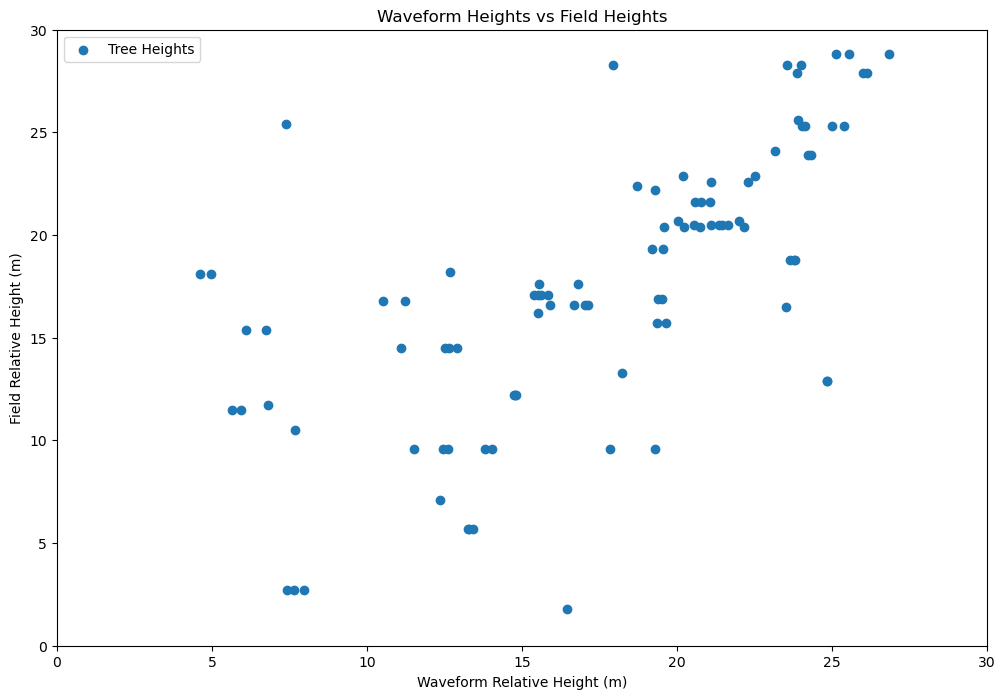

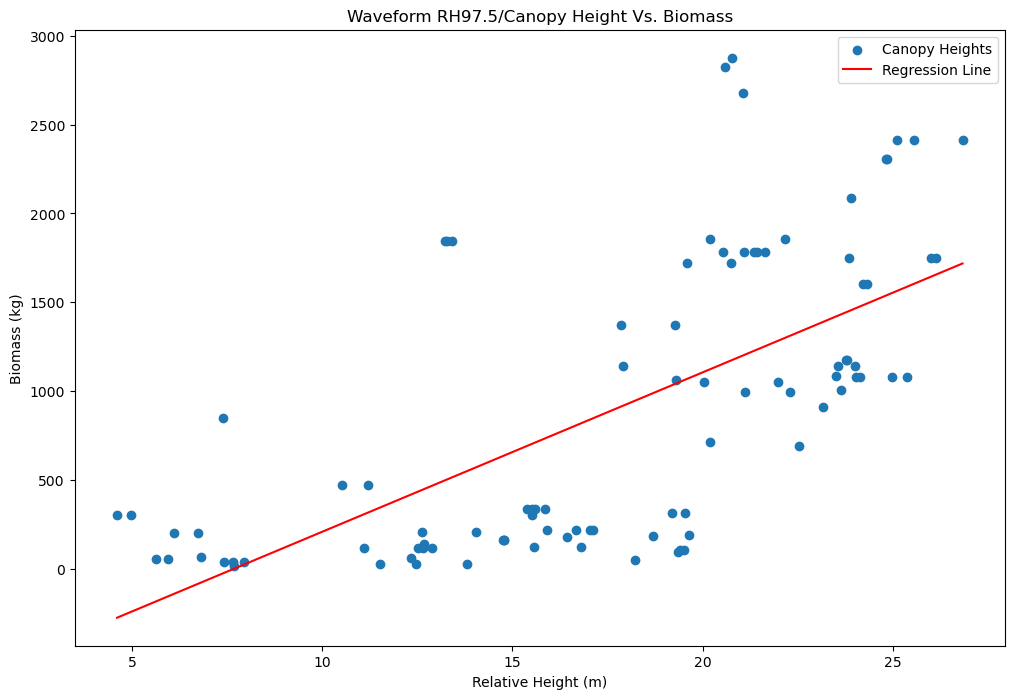

NameError: name 'perform_exponential_regression' is not defined

In [42]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_regression_main(waveform_biomass_data_main_file)

In [17]:
def perform_general_linear_regression(waveform_metric, biomass_values, graph_title):
    '''Fit one linear regression model with all waveform based on waveform metrics and field AGB values'''
    
    regression_model = LinearRegression().fit(waveform_metric, biomass_values)
    regression_predictions = regression_model.predict(waveform_metric)
    
    score = regression_model.score(waveform_metric, biomass_values)
    rmse = np.sqrt(mean_squared_error(biomass_values, regression_predictions))
    
    print(f"Intercept: {regression_model.intercept_}")
    print(f"Coefficients: {regression_model.coef_}")
    print(f"R^2: {score}")
    print(f"RMSE: {rmse}")

    # Sort regression predictions for correct graphing of the regression line
    sorted_indices = np.argsort(regression_predictions.flatten())
    sorted_waveform_canopy_heights = waveform_metric.flatten()[sorted_indices]
    sorted_regression_predictions = regression_predictions[sorted_indices]
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'{graph_title}')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_metric, biomass_values, label='Canopy Heights')
    ax1.plot(sorted_waveform_canopy_heights, sorted_regression_predictions, color='red', label='Regression Line')
    ax1.legend()

    fig.subplots_adjust(wspace=0.5)
    plt.show()
    return sorted_waveform_canopy_heights, sorted_regression_predictions

In [42]:
def perform_clustered_linear_regression(waveform_canopy_heights, biomass_values, number_of_clusters, cluster_group_values, clusters_with_no_data, clusters_with_limited_data, split_percentage):
    '''Create a linear regression for each cluster and plot it'''
    
    # Use the indices to create train and test splits for each array
    train_ind_aggr, test_ind_aggr, train_ind_cluster, test_ind_cluster = split_test_train_cluster_indices(cluster_group_values, number_of_clusters, clusters_with_no_data, clusters_with_limited_data, split_percentage)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    
    # Create a linear regression for all the clusters with all data as training
    for i in range(number_of_clusters):
        train_test_indices_aggregate = np.concatenate((train_ind_cluster[i], test_ind_cluster[i]))

        if i in clusters_with_no_data:
            continue

        # if i in clusters_with_limited_data:
        #     fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
        #     ax1.set_title(f'Waveform Relative Height 97.5 vs. Biomass Cluster {i}')
        #     ax1.set_xlabel('Relative Height (m)')
        #     ax1.set_ylabel('Biomass (kg)')
        #     ax1.scatter(waveform_canopy_heights[train_test_indices_aggregate], biomass_values[train_test_indices_aggregate])
        #     continue

        elevation_train_2 = waveform_canopy_heights[train_ind_cluster[i]]
        elevation_test_2 = waveform_canopy_heights[test_ind_cluster[i]]
        elevation_aggregate_2 = waveform_canopy_heights[train_test_indices_aggregate]
            
        cluster_train_2 = cluster_group_values[train_ind_cluster[i]]
        cluster_test_2 = cluster_group_values[test_ind_cluster[i]]
        
        biomass_train_2 = biomass_values[train_ind_cluster[i]]
        biomass_test_2 = biomass_values[test_ind_cluster[i]]
        biomass_aggregate_2 = biomass_values[train_test_indices_aggregate]

        regression_model_2 = LinearRegression().fit(elevation_aggregate_2, biomass_aggregate_2)
        score_2 = regression_model_2.score(elevation_aggregate_2, biomass_aggregate_2)

        print(f"For cluster {i}")
        print(f"Intercept: {regression_model_2.intercept_}")
        print(f"Coefficients: {regression_model_2.coef_}")
        print(f"Score: {score_2}")

        # Plot scatter points used to create regression in a different color
        ax1.scatter(elevation_aggregate_2, biomass_aggregate_2, label=f"Cluster {i}")

In [48]:
def perform_exponential_regression(waveform_canopy_heights_flattened, biomass_values):
    '''Exponential regression in the form of a * np.exp(b * t) + c to RH and biomass'''
    
    popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, 
                           waveform_canopy_heights_flattened, 
                           biomass_values)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    exponential_predictions = a * np.exp(b * waveform_canopy_heights_flattened) + c

    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'Waveform Relative Height 97.5 and Exponential Relationship Plotted')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_canopy_heights_flattened, biomass_values)
    ax1.plot(np.sort(waveform_canopy_heights_flattened), exponential_predictions[np.argsort(waveform_canopy_heights_flattened)], color='red')

    exponential_rmse = np.sqrt(np.mean((biomass_values - exponential_predictions)**2))
    print(f"Exponential RMSE: {exponential_rmse}")
    print(f"A: {a}, B: {b}, C: {c}")

    return np.sort(waveform_canopy_heights_flattened), exponential_predictions[np.argsort(waveform_canopy_heights_flattened)]

RMSE: 710.7737981777622


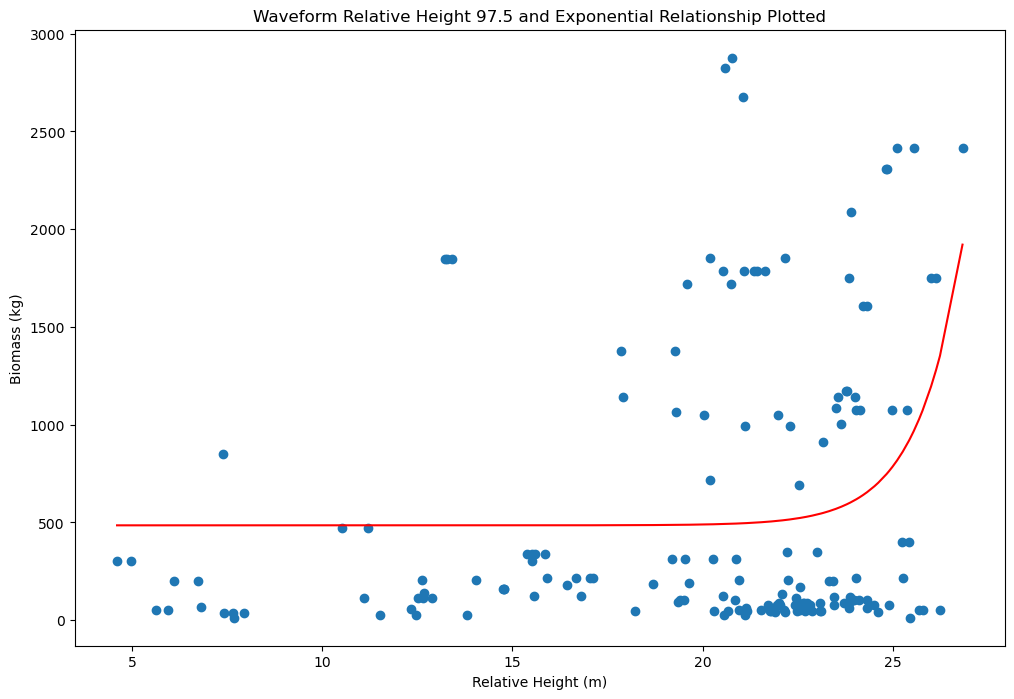

In [39]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_exponential_regression(waveform_biomass_data_main_file)

In [30]:
def perform_polynomial_regression(waveform_biomass_data_file):
    waveform_biomass_data = pd.read_csv(waveform_biomass_data_file)

    # DF Variables
    waveforms_with_biomass = waveform_biomass_data.iloc[:, 10:]
    waveform_elevation_data = waveforms_with_biomass.to_numpy()

    biomass_values = np.array(waveform_biomass_data["Biomass"])
    canopy_bottom_values = waveform_biomass_data["CanopyBottom"].to_numpy()
    surface_elevation_values = waveform_biomass_data["SurfaceElevation"].to_numpy()

    # Cluster vars
    number_of_clusters = 10
    
    # Get metrics
    waveform_elevation_RH10 = waveform_elevation_data[:, [5]]
    waveform_elevation_RH975 = waveform_elevation_data[:, [-2]]

    waveform_RH_start = canopy_bottom_values - surface_elevation_values

    # Filter out waveforms with negative canopy heights
    non_negative_mask = waveform_RH_start >= 0
    waveform_RH_start_filtered = waveform_RH_start[non_negative_mask]
    waveform_elevation_RH10_filtered = waveform_elevation_RH10[non_negative_mask, :]
    waveform_elevation_RH975_filtered = waveform_elevation_RH975[non_negative_mask, :]
    
    biomass_values_masked = biomass_values[non_negative_mask]
    waveform_RH_start_column = waveform_RH_start_filtered.reshape(-1, 1)
    waveform_canopy_heights_RH975 = waveform_RH_start_column + waveform_elevation_RH975_filtered
    waveform_canopy_heights_RH10 = waveform_RH_start_column + waveform_elevation_RH10_filtered

    # Polynomial regression with degree 4
    poly_feat = PolynomialFeatures(degree = 4)
    X_poly = poly_feat.fit_transform(waveform_canopy_heights_RH975)

    reg_model = LinearRegression().fit(X_poly, biomass_values_masked)
    poly_regression_predictions = reg_model.predict(X_poly)
    poly_rmse = np.sqrt(mean_squared_error(biomass_values_masked, poly_regression_predictions))

    # Sort for graphing
    sorted_indices = np.argsort(waveform_canopy_heights_RH975.flatten())
    sorted_waveform_canopy_heights = waveform_canopy_heights_RH975.flatten()[sorted_indices]
    sorted_poly_regression_predictions = poly_regression_predictions[sorted_indices]
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    ax1.set_title(f'Waveform Relative Height 97.5 and Exponential Relationship Plotted')
    ax1.set_xlabel('Relative Height (m)')
    ax1.set_ylabel('Biomass (kg)')
    ax1.scatter(waveform_canopy_heights_RH975, biomass_values_masked)
    ax1.plot(sorted_waveform_canopy_heights, sorted_poly_regression_predictions, color='red')

    print(f"RMSE: {poly_rmse}")

RMSE: 706.4448529882496


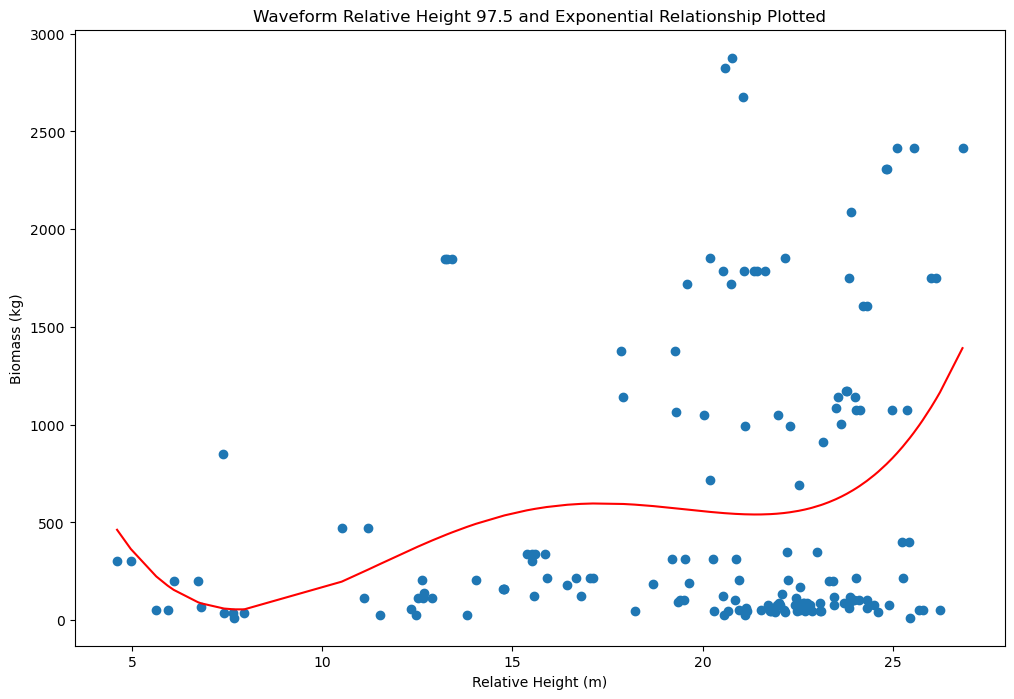

In [41]:
waveform_biomass_data_main_file = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv"
perform_polynomial_regression(waveform_biomass_data_main_file)

In [55]:
def cumulative_waveform_analysis_main(waveform_file, waveform_start_index, waveform_finish_index, biomass_group_num, mapping_tagging_table, apparent_individual_table, waveform_output_file_name):
    '''Main waveform processing function to save waveform and biomass into a csv file compatible for regression analysis and clustering functions.
       Returns a csv file with columns of NEON file number, Pulsenumber, in-situ biomass number associated with waveform, easting, northing, biomass group number
                                                            dummy cluster number, and relative elevation at cumulative intensity intervals of 0.025'''
    # Reading files vars
    waveform_files = waveform_file.split('.')
    pls_file = waveform_files[0] + '.pls'
    wvs_file = waveform_files[0] + '.wvs'
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    readbin_wvs_file = open(wvs_file,"rb")
    readbin_wvs_file.seek(0,0)
    waveform_file_name = waveform_file.split("_")[4]
    
    # Easting, northing, and resolution vars
    min_easting_range = float('inf')
    max_easting_range = float('-inf')
    min_northing_range = float('inf')
    max_northing_range = float('-inf')
    distances_between_waveform_easting = []
    distances_between_waveform_northing = []
    waveform_easting_values = []
    waveform_northing_values = []
    prev_waveform_easting = 0
    prev_waveform_northing = 0

    # Waveform vars - change resolution if necessary
    waveform_cum_energy = []
    original_waveforms_intensity = []
    original_waveforms_elevation = []
    waveform_resolution = 1.5

    # Biomass vars
    biomass_resolution = 1
    count = 0
    shot_numbers_with_existing_biomass = []
    waveform_easting_biomass_found = []
    waveform_northing_biomass_found = []
    total_biomass_nums = []

    # Hardcoded biomass geolocation groups: Easting min, easting max, northing min, northing max
    # Will differ based on NEON site - currently for Harvard Forest data
    group_1_geolocation = [732106, 732147, 4713825, 4713844]
    group_2_geolocation = [723926, 723944, 4707713, 4707732]
    group_3_geolocation = [727586, 727605, 4704386, 4704405]
    group_4_geolocation = [727077, 727097, 4704083, 4704104]
    group_5_geolocation = [728124, 728143, 4702855, 4702877]
    group_6_geolocation = [727049, 727066, 4701145, 4701163]
    group_7_geolocation = [727884, 727902, 4700908, 4700925]
    group_8_geolocation = [725546, 725566, 4700513, 4700534]
    group_9_geolocation = [726500, 726521, 4699044, 4699063]
    group_10_geolocation = [725997, 726016, 4698177, 4698195]
    group_11_geolocation = [725964, 725986, 4696973, 4696994]
    all_grouped_biomass_locations = np.array([group_1_geolocation,
                                    group_2_geolocation,
                                    group_3_geolocation,
                                    group_4_geolocation,
                                    group_5_geolocation,
                                    group_6_geolocation,
                                    group_7_geolocation,
                                    group_8_geolocation,
                                    group_9_geolocation,
                                    group_10_geolocation,
                                    group_11_geolocation])

    # Save biomass geolocation into csv - only necessary if you want to view locations in QGIS
    # biomass_df = pd.DataFrame({'Easting': biomass_easting_arr, 'Northing': biomass_northing_arr})
    # biomass_df.to_csv("valid_biomass_geolocation_info.csv", index=False)

    # Read pls file
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information_header_only(pls_file, lidar_instrument_name)
    
    # Save waveform data into main csv file
    waveform_elevation_axis_numbers = np.round(np.arange(0, 1.01, 0.025), 3)
    columns = ['FileName', 'Pulsenumber', 'Biomass', 'Easting', 'Northing', 'Group', 'Cluster'] + [f"Elevation_{i}" for i in waveform_elevation_axis_numbers]
    biomass_waveform_df = pd.DataFrame(columns=columns)
    
    start_t = time.time()
    # Get biomass geolocation information
    biomass_northing_arr, biomass_easting_arr, biomass_id_arr, biomass_count = get_apparent_individual_biomass_information(apparent_individual_table, mapping_tagging_table, biomass_resolution, False)

    # Save waveform and biomass data into main csv file
    while waveform_start_index <= waveform_finish_index:
        # Read waveform
        waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,instrument_name,lidar_instrument_name,waveform_start_index,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
        cur_waveform_avg_easting = np.mean(waveform_x_axis)
        cur_waveform_avg_northing = np.mean(waveform_y_axis)

        # Calculate distance between waveform for resolution
        if count != 0:
            distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
            distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
            distances_between_waveform_easting.append(distance_between_waveform_easting)
            distances_between_waveform_northing.append(distance_between_waveform_northing)

        waveform_min_easting = waveform_x_axis.min()
        waveform_max_easting = waveform_x_axis.max()
        waveform_min_northing = waveform_y_axis.min()
        waveform_max_northing = waveform_y_axis.max()
        indv_waveform_easting_geolocation = np.mean([waveform_min_easting, waveform_max_easting])
        indv_waveform_northing_geolocation = np.mean([waveform_min_northing, waveform_max_northing])
        
        min_easting_range = min(min_easting_range, waveform_min_easting)
        max_easting_range = max(max_easting_range, waveform_max_easting)
        min_northing_range = min(min_northing_range, waveform_min_northing)
        max_northing_range = max(max_northing_range, waveform_max_northing)

        # Normalize waveform energy
        waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
        original_waveforms_intensity.append(waveform)
        original_waveforms_elevation.append(waveform_z_axis)
        waveform_cum_energy.append(waveform_energy_elev_arr)

        # Find associated biomass value for waveform if it exists
        # Can run find_associated_biomass_waveform_group if you just want to identify which waveforms have biomass
        # biomass_group_found, biomass_group_number = find_associated_biomass_waveform_group(waveform_x_axis, waveform_y_axis, all_grouped_biomass_locations, waveform_start_index)
        biomass_found, biomass_waveform_easting, biomass_waveform_northing = find_associated_biomass_waveform_pulse_number(biomass_northing_arr, biomass_easting_arr, waveform_x_axis, waveform_y_axis, waveform_start_index, 1.0, False)
        if biomass_found:
            shot_numbers_with_existing_biomass.append(waveform_start_index)
            waveform_easting_biomass_found.append(biomass_waveform_easting)
            waveform_northing_biomass_found.append(biomass_waveform_northing)
            waveform_easting_values.append(indv_waveform_easting_geolocation)
            waveform_northing_values.append(indv_waveform_northing_geolocation)

            # This is for a variable resolution (smaller). For now keep it hardcoded
            # waveform_resolution = max(waveform_max_easting - waveform_min_easting, waveform_max_northing - waveform_min_northing)
            # print(waveform_resolution)
            biomass_num = calculate_total_tree_biomass(indv_waveform_northing_geolocation, indv_waveform_easting_geolocation, waveform_resolution, mapping_tagging_table, apparent_individual_table)

            if biomass_num < 1.0:
                print(f"No biomass found for waveform {waveform_start_index}")
                waveform_start_index += 1
                continue
            total_biomass_nums.append(biomass_num)
            
            # Interpolate waveform data for RH metrics
            interpolated_wf, outlier_bool = interpolate_waveform_values(waveform_energy_elev_arr, False)
            new_biomass_row = add_waveform_data_row_with_biomass(waveform_file_name, interpolated_wf, indv_waveform_easting_geolocation, indv_waveform_northing_geolocation, biomass_num, 0, waveform_start_index, biomass_group_num)
            
            # Add information to main dataframe
            biomass_waveform_df = pd.concat([biomass_waveform_df, new_biomass_row], ignore_index=True)
            
        prev_waveform_easting = cur_waveform_avg_easting
        prev_waveform_northing = cur_waveform_avg_northing
        waveform_start_index += 1
        count += 1
    end_t = time.time()
    
    print(f"Processing biomass times: {end_t - start_t}")
    # print(shot_numbers_with_existing_biomass)
    print(total_biomass_nums)

    # Save geolocation of waveforms
    # waveform_location_df = pd.DataFrame({'Pulsenumber': waveform_numbers, 'Easting': waveform_easting_values, 'Northing': waveform_northing_values})
    # waveform_location_df.to_csv("waveform_geolocation_info.csv", index=False)
    
    # Save main biomass waveform data - uncomment to save data
    waveform_output_file_name
    # biomass_waveform_df.to_csv(f"biomass_waveform_data_main_group_{biomass_group_num}_{waveform_file_name}_copy.csv", index=False)

    
    # Range of all the waveforms
    print(f"Easting range: {min_easting_range} to {max_easting_range}")
    print(f"Northing range: {min_northing_range} to {max_northing_range}")
    print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
    print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
    print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
    print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")

    # Interpolate all waveforms to the same size
    interpolated_waveforms = []
    for waveform in waveform_cum_energy:
        interpolated_wf_one, outlier = interpolate_waveform_values(waveform, False)
        interpolated_waveforms.append(interpolated_wf_one)
    interpolated_waveforms = np.array(interpolated_waveforms)


    # Interpolate the waveforms of biomass waveforms
    
    # Calculate slopes of signal vs. relative elevation to perform outlier detection
    waveform_0_25_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.0, 0.25)
    waveform_25_50_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.25, 0.5)
    waveform_50_75_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.5, 0.75)
    waveform_75_100_slopes = calculate_cumulative_signal_slopes(interpolated_waveforms, 0.75, 1.0)
    
    # check_waveform_normality(waveform_0_25_slopes, False)
    # check_waveform_normality(waveform_25_50_slopes, False)
    # check_waveform_normality(waveform_50_75_slopes, False)
    # check_waveform_normality(waveform_75_100_slopes, False)

    outlier_0_25 = perform_normal_waveform_outlier_analysis(waveform_0_25_slopes)
    outlier_25_50 = perform_normal_waveform_outlier_analysis(waveform_25_50_slopes)
    outlier_50_75 = perform_normal_waveform_outlier_analysis(waveform_50_75_slopes)
    outlier_75_100 = perform_normal_waveform_outlier_analysis(waveform_75_100_slopes)

    outliers_aggregated = np.unique(np.concatenate([outlier_0_25, outlier_25_50, outlier_50_75, outlier_75_100]))
    waveform_outliers = interpolated_waveforms[outliers_aggregated]
    # print(len(waveform_outliers))
    # print(total_num_multiple_segments)

    filtered_waveforms = np.delete(interpolated_waveforms, outliers_aggregated, axis=0)
    
    # print(f"Northing Min: {np.min(biomass_northing_arr)}")
    # print(f"Northing Max: {np.max(biomass_northing_arr)}")
    # print(f"Easting Min: {np.min(biomass_easting_arr)}")
    # print(f"Easting Max: {np.max(biomass_easting_arr)}")
    
    # biomass = calculate_total_tree_biomass(biomass_northing, biomass_easting, biomass_resolution, mapping_tagging_table, apparent_individual_table)
    # print(biomass)
    # Plot outliers with all waveforms
    plt.figure(figsize=(12,8))
    plt.title("Waveform Outliers")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    print(len(waveform_outliers))
    for waveform in waveform_outliers:
        plt.plot(waveform[0::2], waveform[1::2], color='red')
    for waveform in filtered_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    plt.show()

    # Plot outlier's original waveform    
    # plotting_waveform_index = 100
    # waveform_example = interpolated_waveforms[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_elevation = original_waveforms_elevation[outliers_aggregated[plotting_waveform_index]]
    # original_waveform_intensity = original_waveforms_intensity[outliers_aggregated[plotting_waveform_index]]

    # fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    # ax1.set_title("Cumulative Signal Return Level Outlier")
    # ax1.set_xlabel("Normalized Cumulative Signal Level")
    # ax1.set_ylabel("Relative Elevation (M)")
    # ax1.plot(waveform_example[0::2], waveform_example[1::2])

    # ax2.set_title("Original Waveform Plot")
    # ax2.set_xlabel("Signal Level")
    # ax2.set_ylabel("Elevation")
    # ax2.plot(original_waveform_intensity, original_waveform_elevation)
    
    # plt.tight_layout()
    # plt.show()

    # for waveform in waveform_outliers:
    #     plt.plot(waveform[0::2], waveform[1::2], color='red')
    # for waveform in filtered_waveforms:
    #     plt.plot(waveform[0::2], waveform[1::2], color='lightgray')
    # plt.show()

Total individual data count: 279
Processing biomass times: 4.07296895980835
[]
Easting range: 727190.3661499996 to 727817.2758000003
Northing range: 4695772.836099997 to 4695818.158849999
Average easting resolution between waveforms: 1.5418316413354516
Average northing resolution between waveforms: 0.07558567165055623
Max easting resolution between waveforms: 56.107174999429844
Max northing resolution between waveforms: 2.591225003823638
64


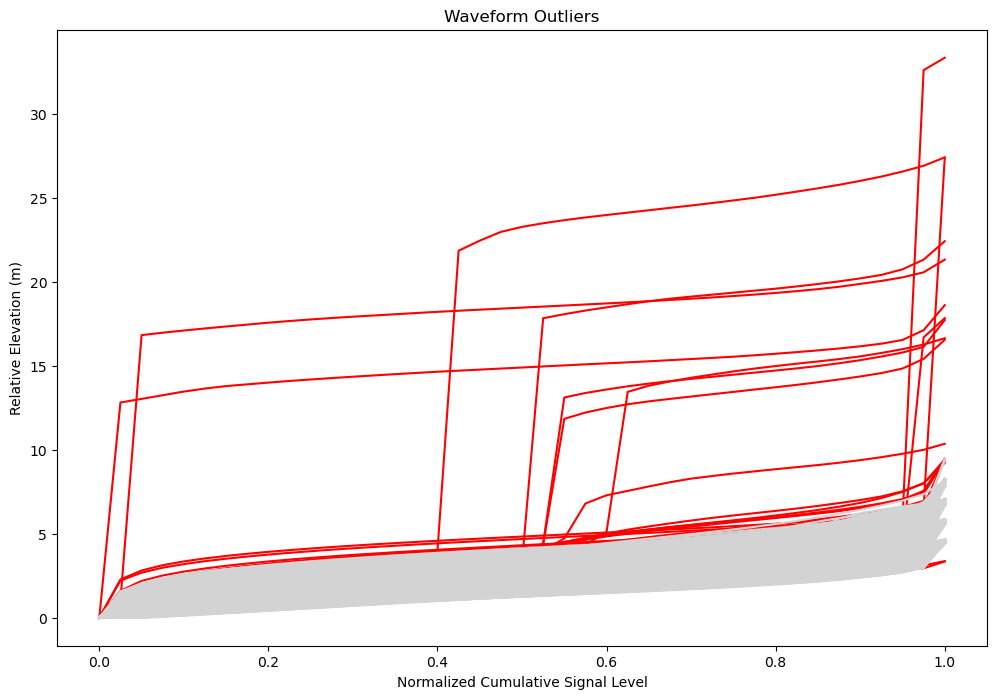

In [42]:
# Add your specific waveform files and in-situ data files here
waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'

mapping_tagging_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_mappingandtagging_harv_2019_08.csv"
apparent_individual_table = "/Users/felixyu/Documents/Remote-Sensing/Field-Data/Field-Data-CSV/HARV-08-2019/vst_apparentindividual_2019_08.csv"

# Change the last parameter with every different file analaysis run
cumulative_waveform_analysis_main(waveform_file_L019, 0, 15000, 4, mapping_tagging_table, apparent_individual_table, "biomass_waveform_data_main_group_9_L010_copy.csv")

In [28]:
def save_waveform_height_data(wave_file, start_index, end_index, waveform_nums):
    '''Save last and first waveform height data points from NEON vegetation structure to a .csv with format:
                                                                        PulseNumber, CanopyBottom, CanopyTop'''
    
    waveform_files = wave_file.split('.')
    pls_file = waveform_files[0] + '.pls'
    wvs_file = waveform_files[0] + '.wvs'
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    readbin_wvs_file = open(wvs_file,"rb")
    readbin_wvs_file.seek(0,0)
    waveform_file_name = wave_file.split("_")[4]
    print(waveform_file_name)
    waveform_height_df = pd.DataFrame(columns=["PulseNumber", "CanopyBottom", "CanopyTop"])
    
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information_header_only(pls_file, lidar_instrument_name) 

    while start_index <= end_index:
        if start_index in waveform_nums:
            waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset, multiple_segments_bool = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,start_index,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)

            canopy_top = waveform_z_axis[0]
            canopy_bottom = waveform_z_axis[-1]
            waveform_height_df.loc[len(waveform_height_df)] = [start_index, canopy_bottom, canopy_top]
        start_index += 1 
            
    waveform_height_df.to_csv(f"waveform_elevations_{waveform_file_name}.csv", index=False)
    return

In [23]:
waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'

# Add pulsenumbers of groups of waveforms to save height data for
L018_group_5 = [7096981, 7097862, 7097863, 7097864, 7097865, 7098199, 7098200, 7098201, 7098202, 7100748, 7101638, 7101642, 7101643, 7101644, 7101979, 7101980, 7106772, 7107653, 7110118, 7110391, 7110393, 7116381, 7116382, 7116383, 7116386, 7116387, 7117343, 7117346, 7117347]
L018_group_7 = [4735586, 4738586, 4738587, 4739580, 4739777, 4740592, 4740593, 4740594, 4740799, 4743571, 4744876, 4747752, 4747753, 4748014]
L019_group_6 = [4719060, 4719061, 4719283, 4719284, 4722245, 4725408, 4725618, 4725619, 4733763, 4734525, 4735518, 4735519, 4735701, 4736478, 4736688, 4738557, 4738760, 4739557, 4739558]
L019_group_4 = [8367850, 8368553, 8369827, 8371033, 8371038, 8371046, 8371641, 8372299,
                8372310, 8372888, 8373529, 8373530, 8373536, 8373537, 8374098, 8374104, 8374746, 8374753,
                8374754, 8374755, 8374756, 8375287, 8377071, 8377088, 8377636, 8378304, 8378305, 8378322,
                8378323, 8378864, 8378865, 8379559, 8379560, 8380126, 8380784, 8380785, 8380794, 8380795,
                8381330, 8381331, 8381340, 8382015, 8384537, 8385141, 8386442, 8386443, 8387125, 8387685,
                8387690, 8387691, 8388362, 8388363, 8388882, 8390063, 8390064, 8390692, 8391246, 8391247,
                8391249, 8391878, 8391879, 8392421, 8392422, 8393652, 8393668, 8394343, 8394362, 8394911,
                8394912, 8394927, 8396759]
L022_group_9 = [3593621, 3594168, 3594173, 3594865, 3594867, 3595415, 3595418, 3595429,
                3595431, 3595432, 3596172, 3596175, 3596684, 3596689, 3597452, 3597974,
                3597975, 3598661, 3599204, 3599205, 3599222, 3599223, 3601511, 3603401,
                3603905, 3604614, 3605184, 3605193, 3605196, 3605885, 3605886, 3605888,
                3605891, 3605892, 3605899, 3606424, 3606438, 3607137, 3610149, 3610150,
                3612645, 3612646, 3612647, 3613295, 3613296, 3613297, 3613862, 3614534,
                3614535]

save_waveform_height_data(waveform_file_L018, 7096981, 7117347, L018_group_5)

L018-1


In [29]:
def get_dtm_surface_elevations(waveform_file_df, dtm_list, dtm_folder):
    '''Get surface elevations from DTM files for each waveform based on geolocation data in waveform csv'''
    
    pulse_numbers = []
    surface_elevation_numbers = []
    canopy_heights = []
    
    for row in waveform_file_df.itertuples():
        easting = row.Easting
        northing = row.Northing
        pulsenumber = row.Pulsenumber

        for file in dtm_list:
            file_easting = int(file.split("_")[4])
            file_northing = int(file.split("_")[5])

            easting_rounded = int(math.floor(easting / 1000) * 1000)
            northing_rounded = int(math.floor(northing / 1000) * 1000)

            if easting_rounded == file_easting and northing_rounded == file_northing:
                xds = rxr.open_rasterio(dtm_folder + file)
                surface_elevation = xds.interp(x=easting, y=northing, band=1).values

                pulse_numbers.append(pulsenumber)
                surface_elevation_numbers.append(surface_elevation)
                
                
    return pulse_numbers, surface_elevation_numbers

In [41]:
dtm_folder = "/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_Biomass_Surface_Elevation/"
dtm_files = ["NEON_D01_HARV_DP3_726000_4699000_DTM.tif", "NEON_D01_HARV_DP3_727000_4700000_DTM.tif", "NEON_D01_HARV_DP3_727000_4701000_DTM.tif", "NEON_D01_HARV_DP3_727000_4704000_DTM.tif", "NEON_D01_HARV_DP3_728000_4702000_DTM.tif", "NEON_D01_HARV_DP3_728000_4703000_DTM.tif"]
waveform_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")

pulsenums, surface_elevations = get_dtm_surface_elevations(waveform_df, dtm_files, dtm_folder)
surface_elevations_df = pd.DataFrame({"Pulsenumber": pulsenums, "SurfaceElevation": surface_elevations})
surface_elevations_df.to_csv("surface_elevation_data.csv")

Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted

In [56]:
def get_cumulative_return_curves(waveform_pulsewaves_start_arr, waveform_pulsewaves_end_arr, pls_file, wvs_file):
    '''K-means cluster helper function'''

    min_easting_range = float('inf')
    max_easting_range = float('-inf')
    min_northing_range = float('inf')
    max_northing_range = float('-inf')
    distances_between_waveform_easting = []
    distances_between_waveform_northing = []
    avg_waveform_distance_easting = 0
    avg_waveform_distance_northing = 0
    prev_waveform_easting = 0
    prev_waveform_northing = 0

    pulsewaves_start = waveform_pulsewaves_start_arr[0]
    current_pulsewaves_batch_counter = 0  
    
    readbin_pls_file = open(pls_file, "rb")
    readbin_pls_file.seek(0, 0)

    readbin_wvs_file = open(wvs_file, "rb")
    readbin_wvs_file.seek(0, 0)
    
    waveform_cum_energy = []

    # Read PLS file
    instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
    offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
    z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
    pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
    sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
    sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
    sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
    sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information_header_only(pls_file, lidar_instrument_name)

    loop_count = 0
    while pulsewaves_start < waveform_pulsewaves_end_arr[len(waveform_pulsewaves_end_arr)-1]:
        
        # Read waveform
        waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,instrument_name,lidar_instrument_name,pulsewaves_start,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
        cur_waveform_avg_easting = np.mean(waveform_x_axis)
        cur_waveform_avg_northing = np.mean(waveform_y_axis)
    
        # Calculate distance between waveform for resolution
        if loop_count != 0:
            distance_between_waveform_easting = abs(cur_waveform_avg_easting - prev_waveform_easting)
            distance_between_waveform_northing = abs(cur_waveform_avg_northing - prev_waveform_northing)
            distances_between_waveform_easting.append(distance_between_waveform_easting)
            distances_between_waveform_northing.append(distance_between_waveform_northing)

            prev_waveform_easting = cur_waveform_avg_easting
            prev_waveform_northing = cur_waveform_avg_northing
    
        waveform_min_easting = waveform_x_axis.min()
        waveform_max_easting = waveform_x_axis.max()
        waveform_min_northing = waveform_y_axis.min()
        waveform_max_northing = waveform_y_axis.max()
        
        min_easting_range = min(min_easting_range, waveform_min_easting)
        max_easting_range = max(max_easting_range, waveform_max_easting)
        min_northing_range = min(min_northing_range, waveform_min_northing)
        max_northing_range = max(max_northing_range, waveform_max_northing)
        
        waveform_energy_elev_arr = normalize_cumulative_return_energy(waveform, waveform_z_axis, False)
        
        # Interesting observation: length is either 80, 96, 112, or 240 (multiple segments in 240) so 40, 48, 56, or 120 values
        waveform_cum_energy.append(waveform_energy_elev_arr)
        if (current_pulsewaves_batch_counter + 1) < len(waveform_pulsewaves_end_arr) and pulsewaves_start == waveform_pulsewaves_end_arr[current_pulsewaves_batch_counter]:
            current_pulsewaves_batch_counter += 1
            pulsewaves_start = waveform_pulsewaves_start_arr[current_pulsewaves_batch_counter]
        else:
            pulsewaves_start += 1
            loop_count += 1
            
    print(pls_file)
    print(f"Easting range: {min_easting_range} to {max_easting_range}")
    print(f"Northing range: {min_northing_range} to {max_northing_range}")
    print(f"Average easting resolution between waveforms: {np.mean(distances_between_waveform_easting)}")
    print(f"Average northing resolution between waveforms: {np.mean(distances_between_waveform_northing)}")
    print(f"Max easting resolution between waveforms: {np.max(distances_between_waveform_easting)}")
    print(f"Max northing resolution between waveforms: {np.max(distances_between_waveform_northing)}")
    print(f"Total size of energy arr: {len(waveform_cum_energy)}")
    return waveform_cum_energy

/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls
Easting range: 726148.0750999994 to 726829.5
Northing range: 4699014.702850001 to 4699136.054709998
Average easting resolution between waveforms: 8.437819013990584
Average northing resolution between waveforms: 47.06228932000027
Max easting resolution between waveforms: 726566.0711849995
Max northing resolution between waveforms: 4699034.650570001
Total size of energy arr: 100000
/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls
Easting range: 727600.40655 to 728640.6800999999
Northing range: 4701032.413599998 to 4702917.794369998
Average easting resolution between waveforms: 4.96748778270017
Average northing resolution between waveforms: 23.617501257130314
Max easting resolution between waveforms: 728387.5145549998
Max northing resolution between waveforms: 4701044.559290003
Total size of energy arr: 200001
/Users/felixyu/Documen

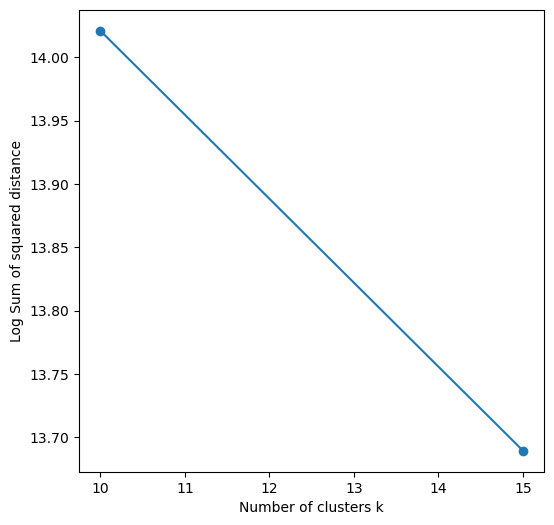

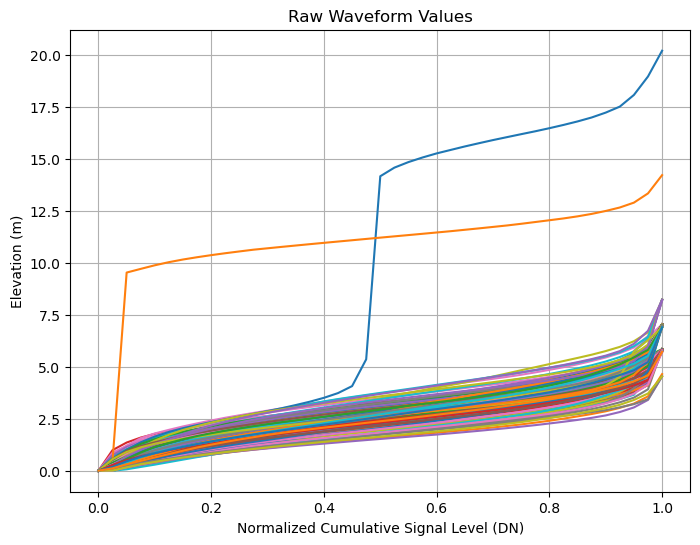

K: 10 Silhouette Score: 0.2807558310330318, Davies Bouldin Score: 0.9107873565021232
K: 15 Silhouette Score: 0.284549148099158, Davies Bouldin Score: 0.7861986762853187


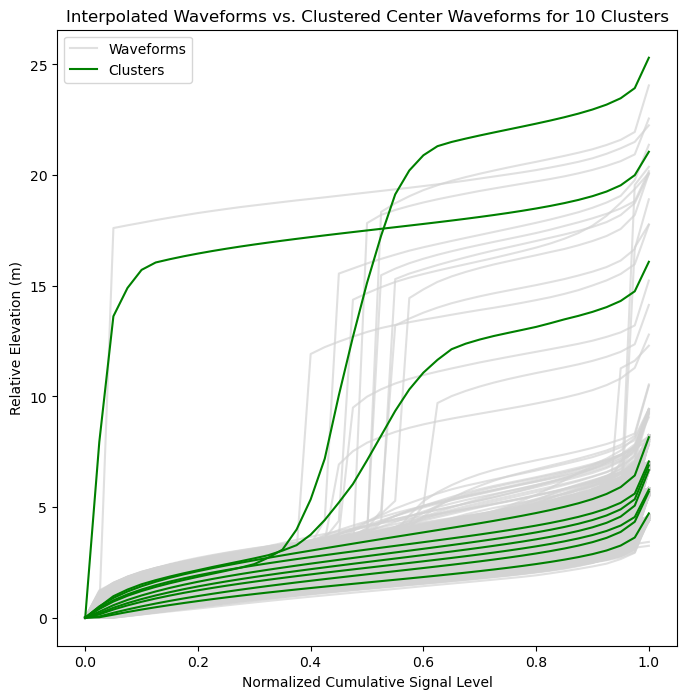

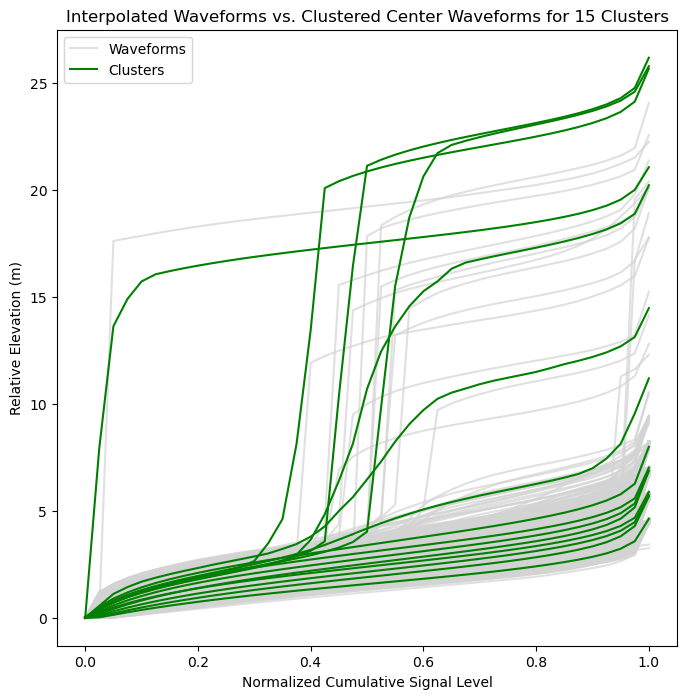

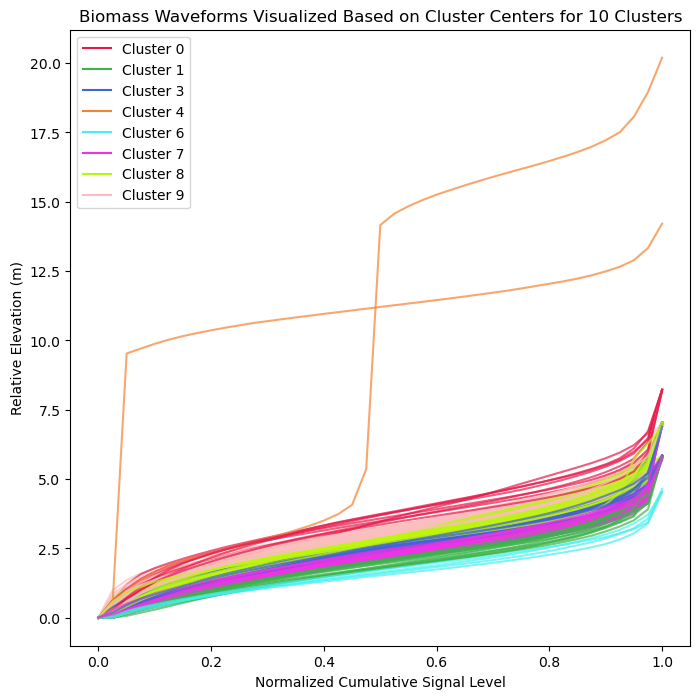

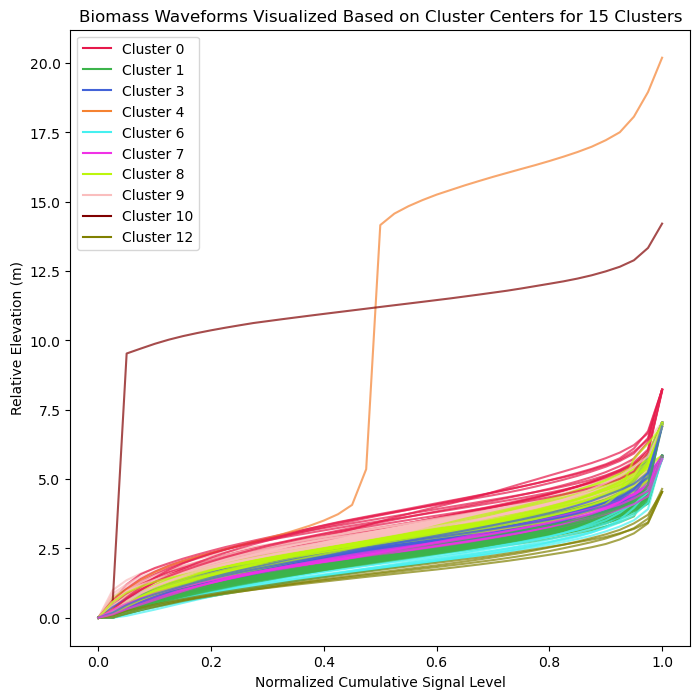

Total processing time: 158.99080300331116


In [59]:
'''
K_means_cluster execution and setup with all waveforms
Cluster 500,000 waveforms with associated biomass values within these clusters
Input assumption: Input csv file with waveform data is sorted such that all waveforms from the same file are contiguous
Output: Cluster assignment for each waveform sorted by pulsenumbers in input csv file order
'''

waveform_start_L022 = 3580000
waveform_end_L022 = 3680000

waveform_start_L018 = 4900000
waveform_end_L018 = 5000000
waveform_start_L018_2 = 7080000
waveform_end_L018_2 = 7180000

waveform_start_L019 = 4700000
waveform_end_L019 = 4800000
waveform_start_L019_2 = 8310000
waveform_end_L019_2 = 8410000

waveform_file_L022 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L022-1_2019082013_1.pls'.split('.')
waveform_file_L019 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L019-1_2019082013_1.pls'.split('.')
waveform_file_L018 = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L018-1_2019082013_1.pls'.split('.')

pls_file_L022 = waveform_file_L022[0] + '.pls'
wvs_file_L022 = waveform_file_L022[0] + '.wvs'
pls_file_L019 = waveform_file_L019[0] + '.pls'
wvs_file_L019 = waveform_file_L019[0] + '.wvs'
pls_file_L018 = waveform_file_L018[0] + '.pls'
wvs_file_L018 = waveform_file_L018[0] + '.wvs'

k_list = [10, 15]

biomass_waveforms_df = pd.read_csv("/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv")
shot_numbers_with_biomass = biomass_waveforms_df["Pulsenumber"].to_numpy()
associated_file_names = biomass_waveforms_df["FileName"].to_numpy()

waveforms_with_biomass_interpolated = []
interpolated_waveforms = []

start = time.time()

cumulative_return_curves_L022 = get_cumulative_return_curves([waveform_start_L022], [waveform_end_L022], pls_file_L022, wvs_file_L022)
cumulative_return_curves_L018 = get_cumulative_return_curves([waveform_start_L018, waveform_start_L018_2], [waveform_end_L018, waveform_end_L018_2], pls_file_L018, wvs_file_L018)
cumulative_return_curves_L019 = get_cumulative_return_curves([waveform_start_L019, waveform_start_L019_2], [waveform_end_L019, waveform_end_L019_2], pls_file_L019, wvs_file_L019)

aggregated_cumulative_return_curves = cumulative_return_curves_L022 + cumulative_return_curves_L018 + cumulative_return_curves_L019

for waveform in aggregated_cumulative_return_curves:
    interpolated_wf_one, outlier = interpolate_waveform_values(waveform, False)

    if not outlier:
        interpolated_waveforms.append(interpolated_wf_one)
interpolated_waveforms = np.array(interpolated_waveforms)

# Get interpolated waveforms of only biomass data
waveforms_intensity_data = np.round(np.arange(0.0, 1.01, 0.025), 3)
waveforms_with_biomass = biomass_waveforms_df.iloc[:, 10:]
elevations_with_biomass_aggregated = (waveforms_with_biomass.apply(lambda row: np.array(row), axis=1)).to_numpy()

# Add intensity data with each elevation array
for elevation_arr in elevations_with_biomass_aggregated:
    waveform_with_biomass_interpolated = np.stack((waveforms_intensity_data, elevation_arr), axis=1).ravel()
    waveforms_with_biomass_interpolated.append(waveform_with_biomass_interpolated)

k_means_classifiers = train_k_means_cluster_cumulative_returns(interpolated_waveforms, k_list, True)
cluster_centers, cluster_assignments = test_k_means_cluster_cumulative_returns(k_means_classifiers, waveforms_with_biomass_interpolated, k_list, True, True)

# Plot cluster centers vs full raw data for each k value
count = 0
for i, cluster_group in enumerate(cluster_centers):
    plt.figure(figsize=(8,8))
    
    for waveform in interpolated_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
        count += 1
        if count > 5000:
            count = 0
            break

    for cluster in cluster_group:
        clustered_signal_levels = cluster[0::2]
        clustered_elevation = cluster[1::2]
        plt.plot(clustered_signal_levels, clustered_elevation, color='green')
    
    plt.title(f"Interpolated Waveforms vs. Clustered Center Waveforms for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
    cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')
    plt.legend(handles=[waveform_legend, cluster_legend])
    plt.show()

# Plot cluster centers vs test data for each k value, highlighted by which cluster they belong to 
for i, cluster_assignment in enumerate(cluster_assignments):
    unique_clusters = np.unique(cluster_assignment)
    # Create a colormap with as many colors as there are clusters.
    colors = [
        '#e6194b',  # Vivid Red
        '#3cb44b',  # Kelly Green
        '#ffe119',  # Bright Yellow
        '#4363d8',  # Royal Blue
        '#f58231',  # Orange
        '#911eb4',  # Purple
        '#46f0f0',  # Cyan/Aqua
        '#f032e6',  # Magenta
        '#bcf60c',  # Lime Green
        '#fabebe',  # Light Pink
        '#800000',  # Maroon
        '#008080',  # Teal
        '#808000',  # Olive
        '#9A6324',  # Brown
        '#000075',  # Navy
    ]
    
    plt.figure(figsize=(8,8))

    # Plot each waveform with its corresponding cluster color.
    for waveform, cluster in zip(waveforms_with_biomass_interpolated, cluster_assignment):
        plt.plot(waveform[0::2], waveform[1::2], color=colors[cluster], alpha=0.7)
    
    # Create legend handles for each cluster color.
    cluster_handles = []
    for cluster in unique_clusters:
        handle = mlines.Line2D([], [], color=colors[cluster], label=f'Cluster {cluster}')
        cluster_handles.append(handle)
    
    plt.title(f"Biomass Waveforms Visualized Based on Cluster Centers for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    plt.legend(handles=cluster_handles)
    plt.show()

# Save cluster assignments
columns = ['FileName', 'Pulsenumber', 'Cluster']

cluster_assignments_df_10 = pd.DataFrame(columns=columns)
cluster_assignments_df_10 = cluster_assignments_df_10.astype({'FileName': 'string','Pulsenumber': 'int64','Cluster': 'int32'})
cluster_assignments_df_15 = cluster_assignments_df_10.copy()

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[0][i]
    }
    cluster_assignments_df_10.loc[len(cluster_assignments_df_10)] = new_cluster_row

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[1][i]
    }
    cluster_assignments_df_15.loc[len(cluster_assignments_df_15)] = new_cluster_row
    
cluster_assignments_df_10.to_csv("waveform_biomass_cluster_assignments_k_10.csv", index=False)
cluster_assignments_df_15.to_csv("waveform_biomass_cluster_assignments_k_15.csv", index=False)

end = time.time()
print(f"Total processing time: {end-start}")

182


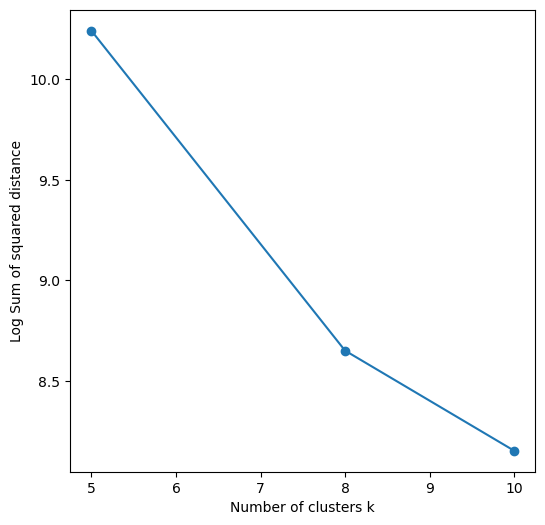

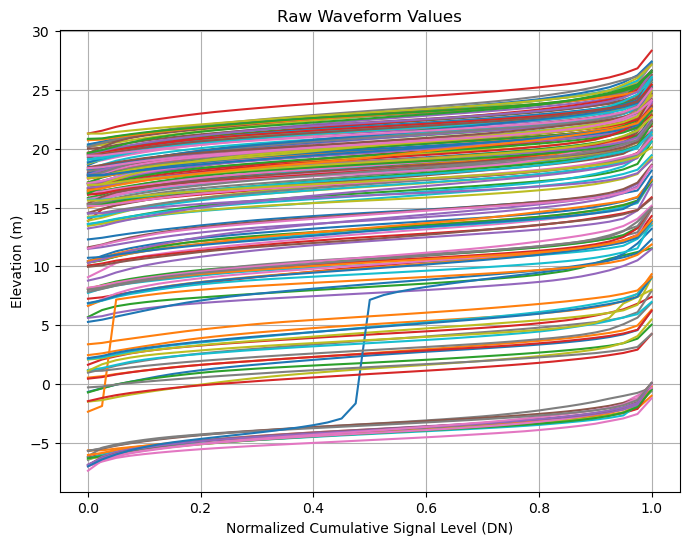

K: 5 Silhouette Score: 0.5246527335710692, Davies Bouldin Score: 0.5425162479125779
K: 8 Silhouette Score: 0.5779369910442247, Davies Bouldin Score: 0.5526953551059985
K: 10 Silhouette Score: 0.5417897820682325, Davies Bouldin Score: 0.45527538321333605


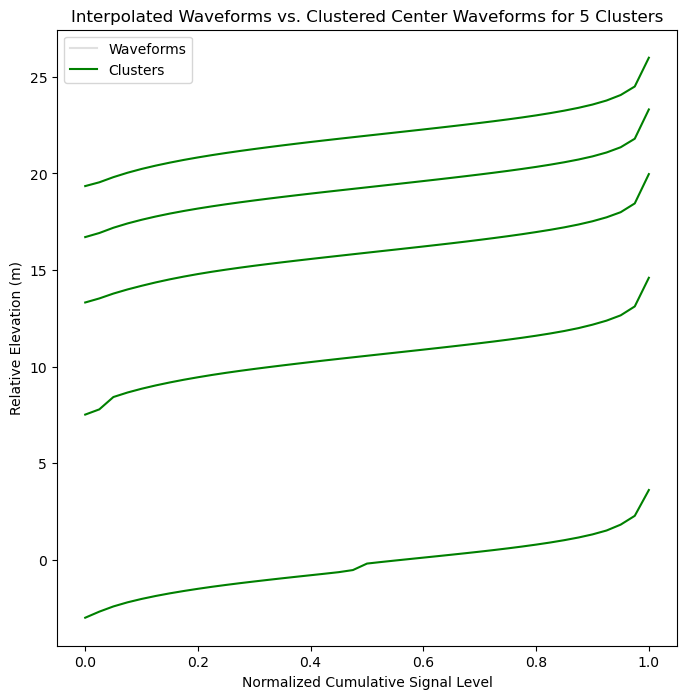

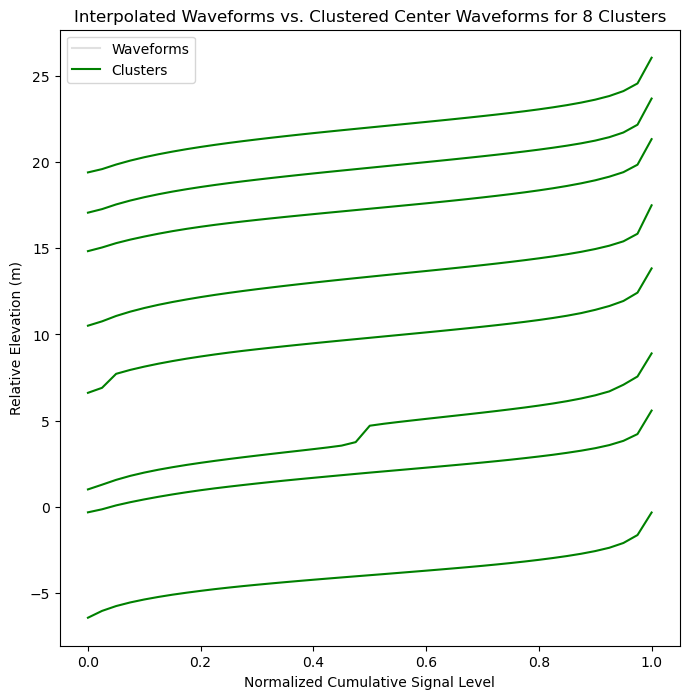

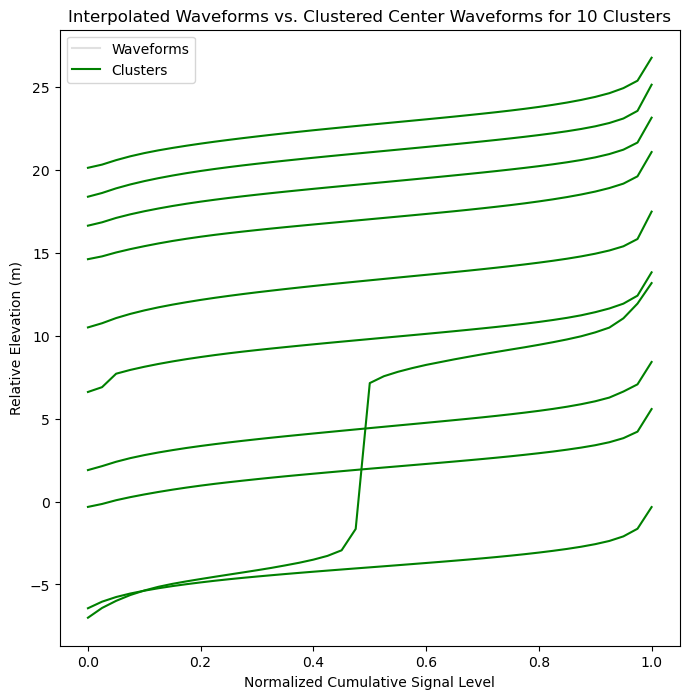

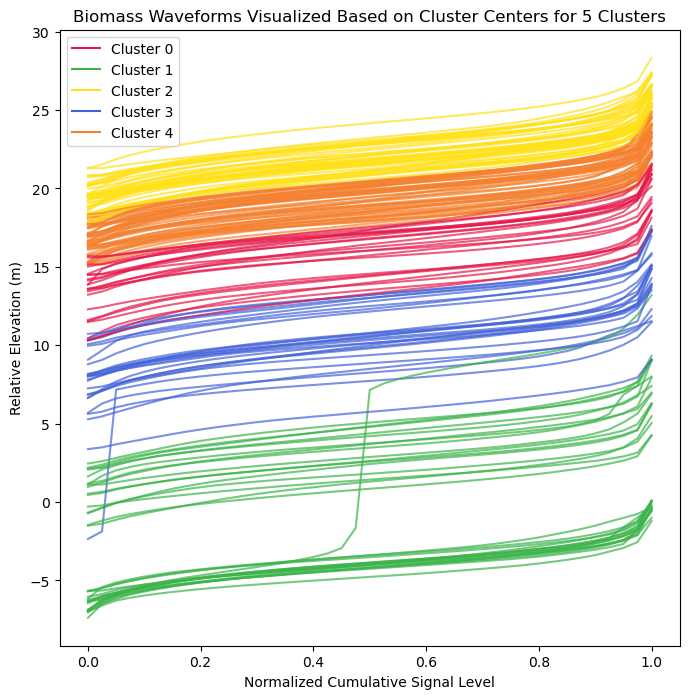

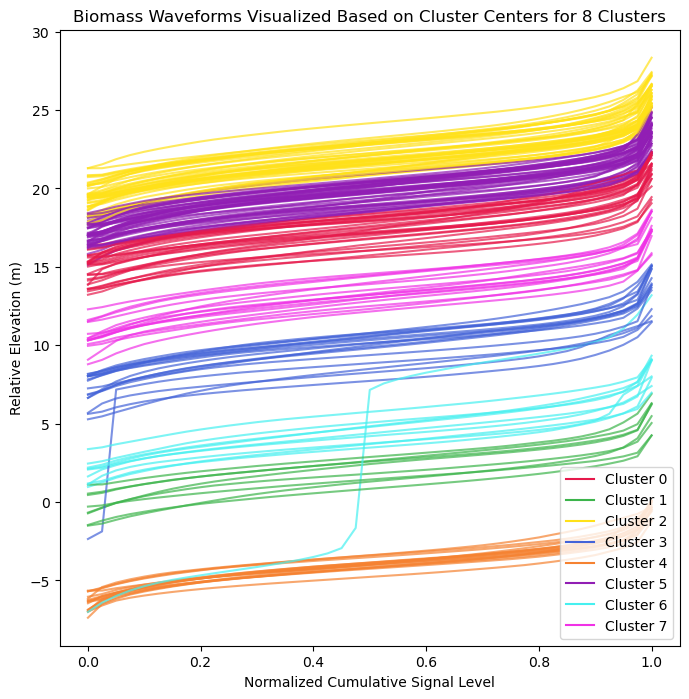

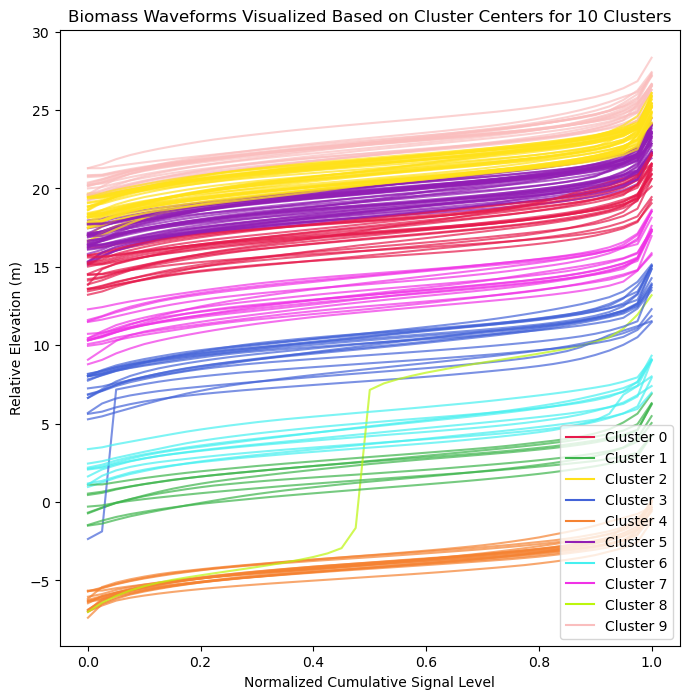

Total processing time: 1.3514060974121094


In [36]:
'''Exact same k-means cluster execution as above but clustering only waveforms with associated biomass values insted of 500,000 waveforms'''

start = time.time()
biomass_waveforms_df = pd.read_csv('/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/biomass_waveform_data_main.csv')

k_list = [5, 8, 10]
waveforms_with_biomass_interpolated = []

pulsenumbers = biomass_waveforms_df["Pulsenumber"].to_numpy()
canopy_top_values = biomass_waveforms_df["CanopyTop"].to_numpy()
biomass_values = biomass_waveforms_df["Biomass"].to_numpy()
canopy_bottom_values = biomass_waveforms_df["CanopyBottom"].to_numpy()
surface_elevation_values = biomass_waveforms_df["SurfaceElevation"].to_numpy()
waveform_elevation_vals = biomass_waveforms_df.iloc[:, 10:].to_numpy()
waveform_elevation_RH975 = waveform_elevation_vals[:, [-2]]

print(len(pulsenumbers))

# Change 0 value to height of the canopy
height_to_bottom_canopy = canopy_bottom_values - surface_elevation_values
waveform_canopy_RH975 = height_to_bottom_canopy + waveform_elevation_RH975.flatten()

# Add canopy height data to waveform elevation data
waveform_elevation_vals += height_to_bottom_canopy[:, np.newaxis]

# Get interpolated waveforms of only biomass data
waveforms_intensity_data = np.round(np.arange(0.0, 1.01, 0.025), 3)

# Add intensity data with each elevation array such that it goes intensity, elevation, intensity2, elevation2...
for elevation_arr in waveform_elevation_vals:
    waveform_with_biomass_interpolated = np.stack((waveforms_intensity_data, elevation_arr), axis=1).ravel()
    waveforms_with_biomass_interpolated.append(waveform_with_biomass_interpolated)

k_means_classifiers = train_k_means_cluster_cumulative_returns(waveforms_with_biomass_interpolated, k_list, True)
cluster_centers, cluster_assignments = test_k_means_cluster_cumulative_returns(k_means_classifiers, waveforms_with_biomass_interpolated, k_list, True, True)

# Plot results 
# Plot cluster centers vs full raw data for each k value
count = 0
for i, cluster_group in enumerate(cluster_centers):
    plt.figure(figsize=(8,8))
    
    for waveform in interpolated_waveforms:
        plt.plot(waveform[0::2], waveform[1::2], color='lightgray', alpha=0.7)
        count += 1
        if count > 5000:
            count = 0
            break

    for cluster in cluster_group:
        clustered_signal_levels = cluster[0::2]
        clustered_elevation = cluster[1::2]
        plt.plot(clustered_signal_levels, clustered_elevation, color='green')
    
    plt.title(f"Interpolated Waveforms vs. Clustered Center Waveforms for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    waveform_legend = mlines.Line2D([], [], color='lightgray', alpha=0.7, label='Waveforms')
    cluster_legend = mlines.Line2D([], [], color='green', label='Clusters')
    plt.legend(handles=[waveform_legend, cluster_legend])
    plt.show()

# Plot cluster centers vs test data for each k value, highlighted by which cluster they belong to 
for i, cluster_assignment in enumerate(cluster_assignments):
    unique_clusters = np.unique(cluster_assignment)
    # Create a colormap with as many colors as there are clusters.
    colors = [
        '#e6194b',  # Vivid Red
        '#3cb44b',  # Kelly Green
        '#ffe119',  # Bright Yellow
        '#4363d8',  # Royal Blue
        '#f58231',  # Orange
        '#911eb4',  # Purple
        '#46f0f0',  # Cyan/Aqua
        '#f032e6',  # Magenta
        '#bcf60c',  # Lime Green
        '#fabebe',  # Light Pink
        '#800000',  # Maroon
        '#008080',  # Teal
        '#808000',  # Olive
        '#9A6324',  # Brown
        '#000075',  # Navy
    ]
    
    plt.figure(figsize=(8,8))
    # Plot each waveform with its corresponding cluster color.
    for waveform, cluster in zip(waveforms_with_biomass_interpolated, cluster_assignment):
        plt.plot(waveform[0::2], waveform[1::2], color=colors[cluster], alpha=0.7)
    
    # Create legend handles for each cluster color.
    cluster_handles = []
    for cluster in unique_clusters:
        handle = mlines.Line2D([], [], color=colors[cluster], label=f'Cluster {cluster}')
        cluster_handles.append(handle)
    
    plt.title(f"Biomass Waveforms Visualized Based on Cluster Centers for {k_list[i]} Clusters")
    plt.xlabel("Normalized Cumulative Signal Level")
    plt.ylabel("Relative Elevation (m)")
    plt.legend(handles=cluster_handles)
    plt.show()

# Save cluster assignments
columns = ['FileName', 'Pulsenumber', 'Cluster']

cluster_assignments_df_10 = pd.DataFrame(columns=columns)
cluster_assignments_df_10 = cluster_assignments_df_10.astype({'FileName': 'string','Pulsenumber': 'int64','Cluster': 'int32'})
cluster_assignments_df_15 = cluster_assignments_df_10.copy()

for i, pulsenum in enumerate(shot_numbers_with_biomass):
    new_cluster_row = {
        'FileName': associated_file_names[i],
        'Pulsenumber': pulsenum,
        'Cluster': cluster_assignments[1][i]
    }
    cluster_assignments_df_10.loc[len(cluster_assignments_df_10)] = new_cluster_row

# for i, pulsenum in enumerate(shot_numbers_with_biomass):
#     new_cluster_row = {
#         'FileName': associated_file_names[i],
#         'Pulsenumber': pulsenum,
#         'Cluster': cluster_assignments[1][i]
#     }
#     cluster_assignments_df_15.loc[len(cluster_assignments_df_15)] = new_cluster_row
    
cluster_assignments_df_10.to_csv("waveform_biomass_cluster_assignments_k.csv", index=False)
# cluster_assignments_df_15.to_csv("waveform_biomass_cluster_assignments_k_15.csv", index=False)

end = time.time()
print(f"Total processing time: {end-start}")